In [3]:
# Gensim
from gensim.models import KeyedVectors, Word2Vec  
# NLP & Transformers
from nltk.corpus import words, stopwords  
from sentence_transformers import SentenceTransformer, models  
from transformers import AutoTokenizer  
from huggingface_hub import login  
# Scientific Computing
import numpy as np  
import pandas as pd  
import scipy.spatial.distance as ssd  
from scipy import spatial, stats  
from scipy.stats import pearsonr, spearmanr, ttest_ind  
from numpy.linalg import norm  
import math    
import operator  
# Machine Learning & Data Analysis
from sklearn.manifold import TSNE   
from sklearn.preprocessing import StandardScaler    
from factor_analyzer import FactorAnalyzer  
# Statsmodels & Stargazer
import statsmodels.api as sm  
import statsmodels.formula.api as smf   
from stargazer.stargazer import Stargazer  
# Plotting
import matplotlib.pyplot as plt  
import matplotlib.cm as cm  
import matplotlib.colors  
from matplotlib.colors import ListedColormap  
# Other Utilities
import sys  
import json  
import csv   
import random  
import pickle  
import networkx as nx  
import copy  
import joblib  
import re  
from collections import Counter, defaultdict  

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    #sys.stdout.write(str(d))
    sys.stdout.write('%d' % d)
    sys.stdout.flush()

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

# calculate CI using bootstrap
def calculateCI2(data,method,n, k):
    m=int(len(data)*k) #take 10% data
    ms=[]
    for j in range(n): #number of samples
        if method=='mean':
                ms.append(np.mean(np.random.choice(data,m)))
        if method=='median':
                ms.append(np.median(np.random.choice(data,m)))
    a,b=[np.percentile(ms,2.5),np.percentile(ms,97.5)]
    
    return (b-a)/2

## Data

In [13]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

In [14]:
# JOB YEAR NPOSTS Medianpay Mineducation
jyn = defaultdict(lambda:defaultdict(lambda:0))
yjn = defaultdict(lambda:defaultdict(lambda:0))
jye = defaultdict(lambda:defaultdict(lambda:0))
yje = defaultdict(lambda:defaultdict(lambda:0))
jyp = defaultdict(lambda:defaultdict(lambda:0))
yjp = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_socName_Nposts_aveMedianPay_aveMinEdu.txt',
          'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        year = int(line_lst[0])
        job = line_lst[1]
        num = int(line_lst[2])
        edu = line_lst[3]
        pay = line_lst[4]
        if year != 2019:
            jyn[job][year] = num
            yjn[year][job] = num
            if edu != 'nan' and edu != 'nan\n': 
                if float(edu) > 0:
                    jye[job][year] = float(edu)
                    yje[year][job.lower()] = float(edu)
            if pay != 'nan' and pay != 'nan\n':
                if float(pay) > 0:
                    jyp[job][year] = float(pay)
                    yjp[year][job] = float(pay)

In [363]:
# soc - pay - education
oe={}
op={}
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/socName_aveMedianPay_aveMinEdu_socGroup.txt','r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        job = line_lst[0]
        op[job] = float(line_lst[1])
        oe[job] = float(line_lst[2])

In [21]:
# JOB-SKILL DATA
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    yjas[year][job][skill] = tfidf
                    
# job - top 5% defining skills
jys = defaultdict(lambda:defaultdict(lambda:[]))
syj = defaultdict(lambda:defaultdict(lambda:[]))
for year in yjas:
    for job in yjas[year]:
        threshold = np.quantile(list(yjas[year][job].values()), [0.95])
        #threshold = np.mean(list(yjas[year][job].values()))
        for skill in yjas[year][job]:
            if yjas[year][job][skill] > threshold:
                jys[job][year].append(skill)
                syj[skill][year].append(job)
        if len(jys[job][year]) < 5:
            #print(job, year)
            del jys[job][year]
            fulllist = syj[skill][year]
            syj[skill][year] = [value for value in fulllist if value != job]
            
# job - SKILL NUMBER
osn = {}
for job in jys:
    snlst = []
    for yr in jys[job]:
        if len(jys[job][yr]) != 0:
            snlst.append(len(jys[job][yr]))
    if snlst:
        osn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
osn = dict(sorted(osn.items(), key=operator.itemgetter(1),reverse=True))

In [35]:
# job vector
# 200 dimension Job-Year-Vector
yjv = defaultdict(lambda:defaultdict(lambda:''))
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    for y in jys[j]:
        jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        yjv[y][j] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        
# job stability from 2010 to 2018: dot product between 2 job vectors
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

## Supplementary Data: Representativeness of Job Ads Data Collected by Burning Glass Technologies

In [5]:
# BLS Education
df_2018e=pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/education.xlsx', 
                      sheet_name="Assignment", header=1)

eduy = []
for i in df_2018e['Typical education needed for entry']:
    if pd.isnull(i) == True:
        eduy.append('nan')
    elif i == 'No formal educational credential':
        eduy.append(0)
    elif i =='High school diploma or equivalent':
        eduy.append(12)  
    elif i in ['High school diploma or equivalent','Some college, no degree','Postsecondary nondegree award']:
        eduy.append(12)
    elif i == "Associate's degree":
        eduy.append(14)
    elif i == "Bachelor's degree":
        eduy.append(16)
    elif i == "Master's degree":
        eduy.append(18)
    elif i == "Doctoral or professional degree":
        eduy.append(21)
df_2018e['eduy']=eduy

In [8]:
# bls pay and employment
df_2018=pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/national_M2018_dl.xlsx')
df_2010=pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/national_M2010_dl.xls')

bls_on18 = {}
bls_op18 = {}
for i, j, k in zip(df_2018['OCC_TITLE'], df_2018['TOT_EMP'], df_2018['A_MEDIAN']):
    if i in yjn[2018] and j != '*'and j !='#':
        bls_on18[i] = j
    if i in yjp[2018] and k != '*' and k !='#':
        bls_op18[i] = k
        
bls_on10 = {}
bls_op10 = {}
for i, j, k in zip(df_2010['OCC_TITLE'], df_2010['TOT_EMP'], df_2010['A_MEDIAN']):
    if i in yjn[2010]and j != '*' and j !='#':
        bls_on10[i] = j
    if i in yjp[2010] and k != '*' and k!= '#':
        bls_op10[i] = k

PearsonRResult(statistic=0.8034817937333437, pvalue=9.100595501679957e-179)
PearsonRResult(statistic=0.7573028144504227, pvalue=1.472688577128141e-145)
PearsonRResult(statistic=0.8665497008620793, pvalue=1.314713665706676e-234)
PearsonRResult(statistic=0.8291506407884582, pvalue=6.969904131565532e-194)
682
PearsonRResult(statistic=0.9155349192602742, pvalue=3.7376760679851597e-271)


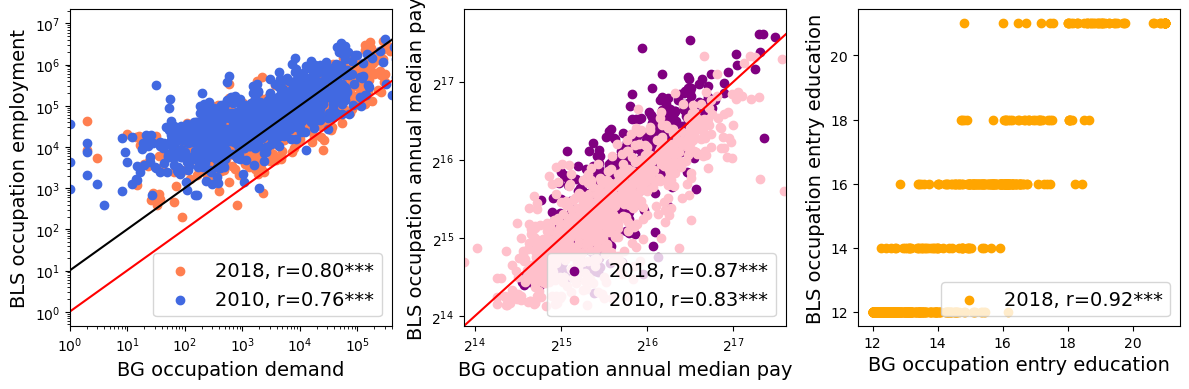

In [10]:
fig = plt.figure(figsize=(12,4))
ax0 = fig.add_subplot(131)
bls_bgon = {}
for j in bls_on18:
    bls_bgon[j] = (yjn[2018][j], bls_on18[j])
x,y = zip(*list(bls_bgon.values()))
plt.scatter(x,y,color="coral", label='2018, r=0.80'+ '***')
corr1=pearsonr(np.log(x),np.log(y))
print(corr1)

bls_bgon = {}
for j in bls_on10:
    bls_bgon[j] = (yjn[2010][j], bls_on10[j])
x,y = zip(*list(bls_bgon.values()))
plt.scatter(x,y,color="royalblue", label='2010, r=0.76'+ '***')
corr2=pearsonr(np.log(x),np.log(y))
print(corr2)

#plt.ylim(1,4000000)
plt.xlim(1,400000)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('BLS occupation employment', fontsize=14)
plt.xlabel('BG occupation demand',fontsize=14)
plt.plot([1,10**6], [1,10**6], 'r-')
plt.plot([1,10**6], [10,10**7], 'k-')
plt.legend(fontsize=14, loc=4)

ax0 = fig.add_subplot(132)
bls_bgop = {}
for j in bls_op18:
    bls_bgop[j] = (yjp[2018][j], float(bls_op18[j]))
x,y = zip(*list(bls_bgop.values()))
plt.scatter(x,y,color="purple", label='2018, r=0.87'+ '***')
corr1=pearsonr(np.log(x), np.log(y))
print(corr1)

bls_bgop = {}
for j in bls_op10:
    bls_bgop[j] = (yjp[2010][j], float(bls_op10[j]))
x1,y1 = zip(*list(bls_bgop.values()))
plt.scatter(x1,y1,color="pink", label='2010, r=0.83'+ '***')
corr2=pearsonr(np.log(x1), np.log(y1))
print(corr2)

plt.ylabel('BLS occupation annual median pay',fontsize=14)
plt.xlabel('BG occupation annual median pay',fontsize=14)
plt.xlim(15000, 200000)
plt.ylim(15000, 250000)
plt.plot([1,10**6], [1,10**6], 'r-')
plt.xscale('log', base=2)
plt.yscale('log', base=2)
plt.legend(fontsize=14, loc=4)


ax0 = fig.add_subplot(133)
bls_bgoe = {}
for i, j in zip(df_2018e['2018 National Employment Matrix title and code'], 
               df_2018e['eduy']):
    if i.lower() in yje[2018] and j != 'nan' and j > 0: #and j != 13:
        bls_bgoe[i.lower()] = (yje[2018][i.lower()], j)
print(len(bls_bgoe))
x,y = zip(*list(bls_bgoe.values()))
plt.scatter(x,y,color="orange", label='2018, r=0.92'+ '***')
plt.ylabel('BLS occupation entry education',fontsize=14)
plt.xlabel('BG occupation entry education',fontsize=14)
plt.legend(fontsize=14, loc=4)
corr=pearsonr(x, y)
print(corr)
plt.tight_layout()

plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/BGValidation.pdf') 

## Supplementary Methods - Replication of Deming and Noray's (2020) Job Skill Change Measurement

In [57]:
# read in saved data
occ_y_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
occ_y_sfreq = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occ_year_skill_freq_emp.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        occ = linelst[0]
        year = linelst[1]
        sfreqs = linelst[2:]
        for s in sfreqs:
            sk = s.split("_")[0]
            freq = int(s.split("_")[1])
            occ_y_skill_freq[occ][year][sk] = freq
            occ_y_sfreq[occ][year] += freq
            
occ_y_freq = defaultdict(lambda:defaultdict(lambda:0))            
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occ_year_npost_emp.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        occ = linelst[0]
        year = linelst[1]
        freq = int(linelst[2])
        occ_y_freq[occ][year] = freq

In [62]:
# calculate job skill change and save data
# weights
jw1 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if '2010' in occ_y_sfreq[j] and '2018' in occ_y_sfreq[j]:
            jw1[j] = (occ_y_sfreq[j]['2010'] / occ_y_sfreq[j]['2018']) / (occ_y_freq[j]['2010']/occ_y_freq[j]['2018'])
            if jw1[j] > 1:
                jw1[j] = 1
                
jw2 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if '2007' in occ_y_sfreq[j] and '2019' in occ_y_sfreq[j]:
            jw2[j] = (occ_y_sfreq[j]['2007'] / occ_y_sfreq[j]['2019']) / (occ_y_freq[j]['2007']/occ_y_freq[j]['2019'])
            if jw2[j] > 1:
                jw2[j] = 1
                
# skill probability
jyspro = copy.deepcopy(occ_y_skill_freq)
for j in jyspro:
    for y in jyspro[j]:
        for s in jyspro[j][y].keys():
            jyspro[j][y][s] = jyspro[j][y][s]/occ_y_freq[j][y]
            
# job change
jyc = defaultdict(lambda:defaultdict(lambda:0))
occsc79=defaultdict(lambda:0)
occsc80=defaultdict(lambda:0)
for j in jyspro:
    if '2007' in jyspro[j] and '2019' in jyspro[j]:
        # get the union of skills of 2 years
        alls = set(jyspro[j]['2007'].keys()).union(set(jyspro[j]['2019'].keys()))
        # skill probability change
        for s in alls:
            jyc[j]['07-19'] += abs(jyspro[j]['2019'][s] - jyspro[j]['2007'][s])
        jyc[j]['07-19'] = jyc[j]['07-19']*jw2[j]
        occsc79[j] = jyc[j]['07-19']
            
    if '2010' in jyspro[j] and '2018' in jyspro[j]:
        # get the union of skills of 2 years
        alls = set(jyspro[j]['2010'].keys()).union(set(jyspro[j]['2018'].keys()))
        # skill probability change
        for s in alls:
            jyc[j]['10-18'] += abs(jyspro[j]['2018'][s] - jyspro[j]['2010'][s])
        jyc[j]['10-18'] = jyc[j]['10-18']*jw1[j]
        occsc80[j] = jyc[j]['10-18']
        
# save 
df79 = pd.DataFrame()
sorted79 =  dict(sorted(occsc79.items(), key=operator.itemgetter(1), reverse=True))
df79['SOC'] = list(sorted79.keys())
df79["SkillChange"] = list(sorted79.values())
df79.to_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/0719Soc6SkillChange_emp.csv')

df80 = pd.DataFrame()
sorted80 =  dict(sorted(occsc80.items(), key=operator.itemgetter(1), reverse=True))
df80['SOC'] = list(sorted80.keys())
df80["SkillChange"] = list(sorted80.values())
df80.to_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/1018Soc6SkillChange_emp.csv')

In [3]:
# data in Deming and Noray (2020) appendix
OriData = pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/QJE_SOC6Change.xlsx')
SOCR = {}
for i, j in zip(OriData["occupation_title"], OriData["RATE"]):
    SOCR[str(i)] = j

# replication
ReplData = pd.read_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/0719Soc6SkillChange_emp.csv')
re = {}
for i, j in zip(ReplData['SOC'], ReplData["SkillChange"]):
    re[str(i)] = j

# calculate correlation   
repl = {}
for j in SOCR:
    if j in re:
        repl[j] = (SOCR[j],re[j])

x,y = zip(*list(repl.values()))
print(pearsonr(x,y))

(0.8696114554674294, 2.0059318581748458e-88)


## Supplementary Methods - Cluster Approach to Measure Occupational Skill Change

In [ ]:
# skill network
graph_dict = {}
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/skillpair_pmi.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        graph_dict[(int(line_lst[0]), int(line_lst[1]))] = float(line_lst[2])
        
        
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/2010_skill_id_name.json','r')as f:
    name_dict = json.load(f)
name_index = {name_dict[i]:int(i) for i in name_dict}
name_dict = {int(i):name_dict[i] for i in name_dict.keys()}

PMI = nx.Graph()
for pair in graph_dict:
    if graph_dict[pair] > 0:
        i, j = pair
        PMI.add_edge(name_dict[i], name_dict[j], weight = graph_dict[pair])

# pair-weight
pw={(i,j):PMI[i][j]['weight'] for i,j in PMI.edges()}
# node1-node2-weight
ppmi = defaultdict(lambda:defaultdict(lambda:0))
for i,j in pw:
    ppmi[i][j] = pw[(i,j)]
# node1 - sorted connected nodes
spmi = defaultdict(lambda:[])
for i in ppmi:
    sl = sorted([(p,j) for j, p in ppmi[i].items()],reverse=True)
    sj = [j for p, j in sl]
    spmi[i] = sj

In [ ]:
# identify skill communities
partition = community_louvain.best_partition(PMI)
modularity = round(community_louvain.modularity(partition, PMI), 2) # 0.51
with open('partition_0.0_0.0_6_0.51.txt','w') as f:
        for k,v in partition.items():
            line = '\t'.join([k, str(v)])
            f.write(line + '\n')

In [66]:
# skill--community
partition = defaultdict(lambda:[])
sp = {}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/partition_0.0_0.0_6_0.51.txt','r') as f:
    for line in f:
        skill = line.split('\t')[0]
        group = int(line.split('\t')[1])
        partition[group].append(skill)
        sp[skill] = group

# community labels
labels = ['business and managerial skills', 'engineering, technical, and manual skills', 
          'computer and programming skills', 'clerical and analytical skills', 
          'scientific and research skills', 'medical and health skills']

In [69]:
# job - skill community - frequency
jyscf = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for job in jys:
    for year in jys[job]:
        for s in jys[job][year]:
            if s in sp:
                jyscf[job][year][sp[s]] += 1
                
# job - skill community - share change
occ_scc = defaultdict(lambda:0)
for occ in jyscf:
    if 2010 in jyscf[occ] and 2018 in jyscf[occ]:
        skills = set(jyscf[occ][2010].keys()).union(jyscf[occ][2018].keys())
        for skill in skills:   
            occ_scc[occ] += abs(jyscf[occ][2018][skill]/sum(jyscf[occ][2018].values()) - 
                          jyscf[occ][2010][skill]/sum(jyscf[occ][2010].values())) 
# sort the occupation by skill change
sorted_occscc = dict(sorted(occ_scc.items(), key=operator.itemgetter(1), reverse=True))

In [70]:
# skill cluster share change for two occupations
# computer programmers
# skill cluster freq for each year
fil_pc10 = defaultdict(lambda:0)
for k in jys["Computer Programmers"][2010]:
    if k in sp:
        fil_pc10[sp[k]] += 1
fil_pc18 = defaultdict(lambda:0)
for k in jys["Computer Programmers"][2018]:
    if k in sp:
        fil_pc18[sp[k]] += 1
allcc = set(fil_pc10.keys()).union(fil_pc18.keys())
# skill cluster share change
sdiffCC = {}
for k in allcc:
    sdiffCC[k] = abs(fil_pc18[k]/sum(fil_pc18.values()) - fil_pc10[k]/sum(fil_pc10.values()))

# Food Batchmakers
fil_pb10 = defaultdict(lambda:0)
for k in jys['Food Batchmakers'][2010]:
    if k in sp:
        fil_pb10[sp[k]] += 1
fil_pb18 = defaultdict(lambda:0)
for k in jys['Food Batchmakers'][2018]:
    if k in sp:
        fil_pb18[sp[k]] += 1
allbc = set(fil_pb10.keys()).union(fil_pb18.keys())

sdiffBC = {}
for k in allbc:
    sdiffBC[k] = abs(fil_pb18[k]/sum(fil_pb18.values()) - fil_pb10[k]/sum(fil_pb10.values()))

In [73]:
# 200 dimension Job-Year-Vector
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    for y in jys[j]:
        jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

# job change from 2010 to 2018: 1 - dot product between 2 job vectors
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

In [71]:
occ_scc['Computer Programmers'], occ_scc["Food Batchmakers"]

(0.19677965685672907, 0.3553921568627451)

(0.7618382894447562, 7.380695063066697e-139)


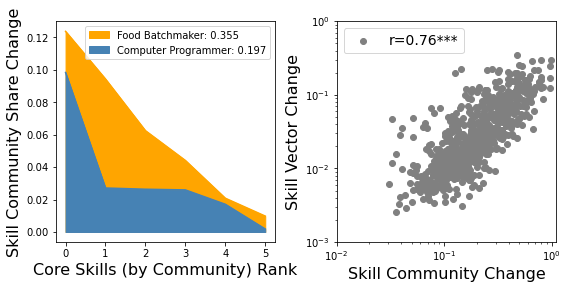

In [74]:
fig = plt.figure(figsize=(8,4))
ax2 = fig.add_subplot(121)
sb = sorted(sdiffBC.values(), reverse=True)
plt.plot(sb, color="orange")
plt.fill_between(range(len(sb)),sb,0,color="orange", label="Food Batchmaker: 0.355")
sc=sorted(sdiffCC.values(), reverse=True)
plt.plot(sc, color="steelblue")
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="Computer Programmer: 0.197")
plt.legend(fontsize=10)
plt.ylabel("Skill Community Share Change", fontsize=16)
plt.xlabel("Core Skills (by Community) Rank", fontsize=16)        


ax2 = fig.add_subplot(122)
scc_vec = {}
for j in sorted_occscc:
    if j in jtr:
        scc_vec[j] = (sorted_occscc[j],jtr[j])
x,y = zip(*list(scc_vec.values()))
print(pearsonr(np.log(x),np.log(y)))
plt.scatter(x,y, label="r=0.76***", color="grey")

plt.xlabel("Skill Community Change", fontsize=16)
plt.ylabel("Skill Vector Change", fontsize=16)
plt.legend(loc=2, fontsize=14)

plt.ylim(1/1000,1)
plt.xlim(1/100,1.1)
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/SI/SI_ClusterVector.pdf') 

## Supplemenatry Method - Embedding Validation: Internal Validation

### Skill vector t-SNE plot for skills with skill family label

In [11]:
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/skill_skillclusterfamily.json', 'r') as f:
    SF = json.load(f)
# Convert both keys and values to lowercase
F = {k.lower(): v.lower() for k, v in SF.items()}

In [15]:
# Construct word vectors dictionary
S={}
for v in F:
    if v in model.wv:
        vs=model.wv[v]
        S[v]=vs

# prepare the data for dimension reduction visualization
data=np.array(list(S.values()))

In [16]:
random.seed(20)
# obstain 2D coordinates by embedding 
coordsTSNE = TSNE(n_components=2, random_state=20).fit_transform(data)
xTSNE,yTSNE=coordsTSNE.T

In [ ]:
# Save the coordinates and corresponding keys (j) to a CSV file
output_file = "/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/revision/NC/results/skill_coordsTSNE_skillfamily.csv"

with open(output_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Key", "xTSNE", "yTSNE"])  # Header
    for key, (x, y) in zip(S.keys(), coordsTSNE):
        writer.writerow([key, x, y])

In [ ]:
# top 20 family with the most skills
top20fre=sorted([(v,k) for k,v in Counter(F.values()).items()],reverse=True)[:20]
skill_f=[j for i,j in top20fre]

# color skills by top20 family, otherwise set as gray
colors=[]
skill_fs=set(skill_f)
for i in S.keys():
    if F[i] in skill_fs:
        colors.append(skill_f.index(F[i]))
    else:
        colors.append(len(skill_f))

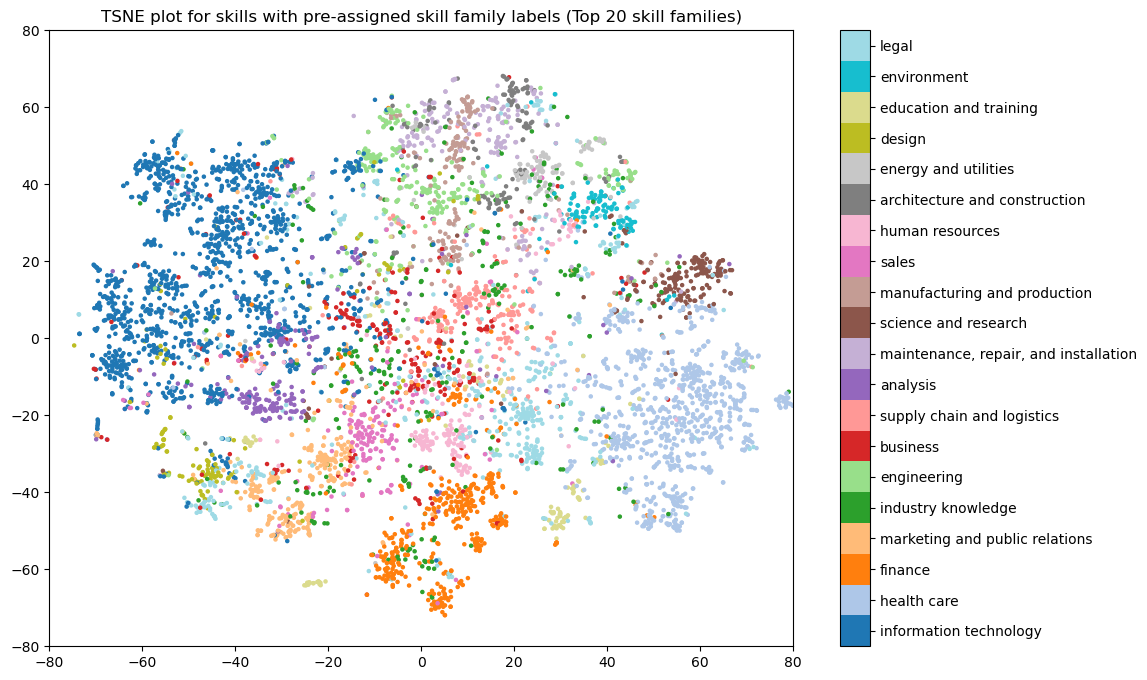

In [18]:
fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(111)
plt.scatter(xTSNE,yTSNE,s=5,c=colors,cmap='tab20')
cbar=plt.colorbar(ticks=np.array(range(20))+0.5)
cbar.ax.set_yticklabels(skill_f) 
plt.xlim(-80,80)
plt.ylim(-80,80)
plt.title('TSNE plot for skills with pre-assigned skill family labels (Top 20 skill families)')

plt.savefig("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/skill_tsne.pdf", 
            format="pdf", bbox_inches="tight")

### Occupation vector t-SNE plot

In [111]:
# soc hierarchy
socs = pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/nem-occupational-coverage.xlsx')

# Step 1: Replace column names with the values from the third row (index 2)
socs.columns = socs.iloc[2]
# Step 2: Drop the first three rows (index 0, 1, 2)
socs = socs.drop(index=[0, 1, 2]).reset_index(drop=True)

soc2dn={}
soc4dn={}
soc6dn={}
for i,j in zip(socs['Matrix Occupation Code'], socs['Matrix Occupation Title']):
    # 2 digit
    if i[-4:]=='0000':
        soc2dn[i] = j.lower().replace("occupations", "").strip()
    elif i[-2:]=='00':
        soc4dn[j.lower()]=i
    else:
        soc6dn[j.lower()] = i

# 200 dimension Job-Year-Vector
yjv = defaultdict(lambda:defaultdict(lambda:''))
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    if 2010 in jys[j] and 2018 in jys[j] and j in jyn:
        if jyn[j][2010] > 100 and jyn[j][2018] > 100:
            for y in jys[j]:
                jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
                yjv[y][j] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

soc6to2n={}
for j in list(yjv[2018].keys()):
    if j.lower() in soc6dn:
        soc2d=soc6dn[j.lower()][:2]+'-0000'
        soc6to2n[j]=soc2dn[soc2d]

In [113]:
# prepare the data for dimension reduction visualization
# use subset of occupations with 2-digit labels
S = {j: yjv[2018][j] for j in soc6to2n} 
data=np.array(list(S.values()))

random.seed(20)
# obstain 2D coordinates by embedding 
coordsTSNE = TSNE(n_components=2, random_state=20).fit_transform(data)
xTSNE,yTSNE=coordsTSNE.T

In [ ]:
# Save the coordinates and corresponding keys (j) to a CSV file
output_file = "/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occupation_coordsTSNE.csv"

with open(output_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Key", "xTSNE", "yTSNE"])  # Header
    for key, (x, y) in zip(S.keys(), coordsTSNE):
        writer.writerow([key, x, y])

In [29]:
input_file = "/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occupation_coordsTSNE.csv"
df = pd.read_csv(input_file)
# Access xTSNE and yTSNE as lists or arrays
xTSNE = df["xTSNE"].to_numpy()
yTSNE = df["yTSNE"].to_numpy()
keys = df["Key"].tolist()

In [114]:
# top 20 family with the most skills
top20fre=sorted([(v,k) for k,v in Counter(soc6to2n.values()).items()],reverse=True)[:20]
occ_f=[j for i,j in top20fre]

# color skills by top20 family, otherwise set as gray
colors=[]
occ_fs=set(occ_f)
for i in keys:
    if soc6to2n[i] in occ_fs:
        colors.append(occ_f.index(soc6to2n[i]))
    else:
        colors.append(len(occ_f))

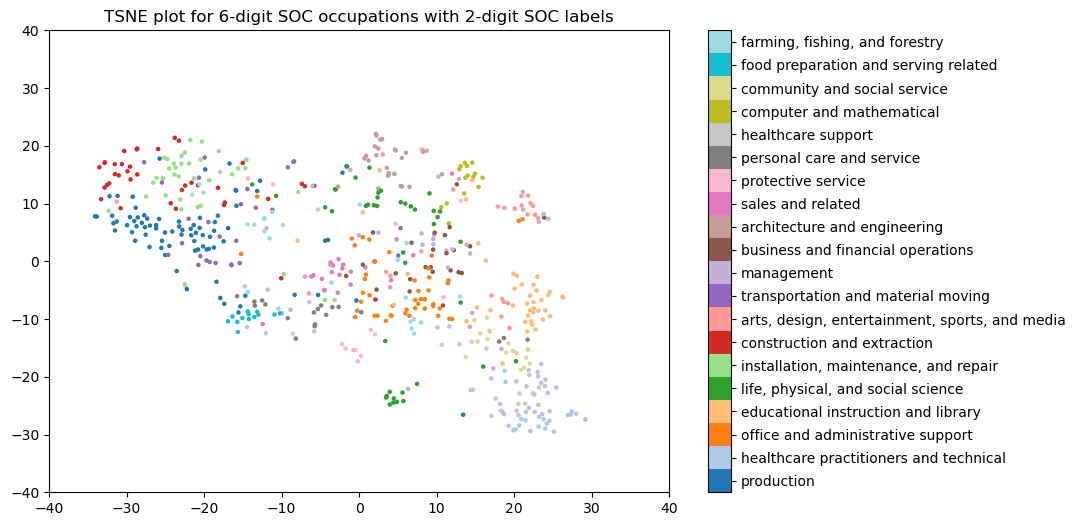

In [115]:
# TSNE
fig = plt.figure(figsize=(10, 6),facecolor='white')
ax = fig.add_subplot(111)
plt.scatter(xTSNE,yTSNE,s=5,c=colors,cmap='tab20')
cbar=plt.colorbar(ticks=np.array(range(20))+0.5)
cbar.ax.set_yticklabels(occ_f) 
plt.xlim(-40,40)
plt.ylim(-40,40)
plt.title('TSNE plot for 6-digit SOC occupations with 2-digit SOC labels')
plt.savefig("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/occupation_tsne.pdf", 
            format="pdf", bbox_inches="tight")
plt.show()

### Comparing occupational skill vectors with static word vectors

In [116]:
# all skills
skills = list(model.wv.index_to_key)

# 200 dimension Job-Year-Vector
yjv = defaultdict(lambda:defaultdict(lambda:''))
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    if 2010 in jys[j] and 2018 in jys[j] and j in jyn:
        if jyn[j][2010] > 100 and jyn[j][2018] > 100:
            for y in jys[j]:
                jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
                yjv[y][j] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

owv_par = {}
owv_parw = {}
oran_v = {}
oran_w = {}
seed=113
for o in yjv[2018]:
    seed+=1
    random.seed(seed)
    # Normalize the string and replace special characters
    words = o.lower().replace("--", " ").replace("-", " ").replace("/", " ").replace(",", "").split()
    # Generate all n-grams (from unigrams to n-grams)
    ngrams = [" ".join(words[i:j]) for i in range(len(words)) for j in range(i + 1, len(words) + 1)]
    # Keep only n-grams found in skills
    found_ngrams = [ng for ng in ngrams if ng in skills]
    # Filter out smaller n-grams that are encompassed by larger ones
    mw = []
    for ng in found_ngrams:
        if not any(ng in other and ng != other for other in found_ngrams):
            mw.append(ng)
    
    # Calculate embeddings for the filtered n-grams
    if len(mw) > 0:  # Partial match
        owv_par[o] = np.mean([model.wv[s] for s in mw if s in model.wv], axis=0)
        owv_parw[o] = mw
        rw = random.sample(skills, len(owv_parw[o]))
        oran_v[o] = np.mean([model.wv[s] for s in rw if s in model.wv], axis=0)
        oran_w[o] = rw

In [117]:
# distance between occupation skill vectors and word vectors
osim = {}
seed=1
oran_o={}
keys_list = list(owv_par.keys())
for o in owv_par:
    if o in yjv[2018]:
        # Exclude 'o' from the list
        filtered_keys = [key for key in keys_list if key != 'o']
        oran_o[o] = random.sample(filtered_keys, 1)[0]
        os = np.dot(owv_par[o], yjv[2018][o])/(np.linalg.norm(owv_par[o])* np.linalg.norm(yjv[2018][o]))
        #ors = np.dot(owv_par[oran_o[o]], yjv[2018][oran_o[o]])/(np.linalg.norm(owv_par[oran_o[o]])* np.linalg.norm(yjv[2018][o]))
        ors = np.dot(oran_v[o], yjv[2018][o])/(np.linalg.norm(oran_v[o])* np.linalg.norm(yjv[2018][o]))
        osim[o] = (os, ors)

In [119]:
x, y = zip(*osim.values())

# Perform t-test: Two-Sample t-Test (Unpaired Data)
t_stat, p_value = ttest_ind(x, y, alternative='greater')
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 30.248097847561997, P-value: 9.415635734498561e-88


/var/folders/gl/g3xsl_397tg4jsr3yxz4wmjw0000gq/T/ipykernel_2169/2020550018.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axs[0].boxplot([x, y], labels=['Occupation title word', 'Random word'])


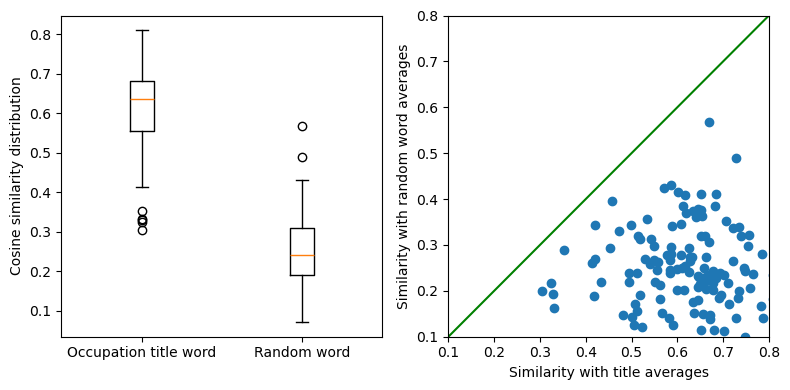

In [120]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# First plot: Boxplot
axs[0].boxplot([x, y], labels=['Occupation title word', 'Random word'])
axs[0].set_ylabel('Cosine similarity distribution')
#axs[0].set_title('Boxplot Comparison')

# Second plot: Scatter plot
axs[1].scatter(x, y)
axs[1].set_xlim(0.1, 0.8)
axs[1].set_ylim(0.1, 0.8)
# axs[1].set_xlabel("Occupation skill and word similarity")
# axs[1].set_ylabel("Occupation skill and random word similarity")
axs[1].set_xlabel("Similarity with title averages")
axs[1].set_ylabel("Similarity with random word averages")
axs[1].axline((0, 0), (1, 1), color='green')
#axs[1].set_title('Scatter Plot Comparison')

# Adjust spacing
plt.tight_layout()
plt.savefig("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/occupation_validation.pdf", 
            format="pdf", bbox_inches="tight")
# Show the combined figure
plt.show()

## Supplemenatry Method - Embedding Validation: Pre-trained LLM

In [62]:
# labor space
base_model = "seongwoon/LAbert"
embedding_model = models.Transformer(base_model) ## Step 1: use an existing language model

pooling_model = models.Pooling(embedding_model.get_word_embedding_dimension()) ## Step 2: use a pool function over the token embeddings
pooling_model.pooling_mode_mean_tokens = True
pooling_model.pooling_mode_cls_token = False
pooling_model.pooling_mode_max_tokens = False
labert = SentenceTransformer(modules=[embedding_model, pooling_model]) ## Join steps 1 and 2 using the modules argument

# Step 1: Define the base model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_model)

### Correlation of pariwise occupation vector similarity

In [121]:
# skill embedding: 200 dimension Job-Year-Vector
yjv = defaultdict(lambda:defaultdict(lambda:''))
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    if 2010 in jys[j] and 2018 in jys[j] and j in jyn:
        if jyn[j][2010] > 100 and jyn[j][2018] > 100:
            for y in jys[j]:
                jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
                yjv[y][j] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

In [122]:
# calculate occupation vectors on labor space
def cleanstring(text):
    text = text.lower()
    text = text.replace("--", " ").replace("-", " ").replace("/", " ").replace(",", "")
    text = text.replace("and", " ").replace("or", " ").replace("all", " ").replace("other", "")
    text = " ".join(text.split())
    return text
                
# 2018 occupation vectors
obert = {}
otoken = {}
for o in list(yjv[2018].keys()):
    cleano = cleanstring(o)
    sts = tokenizer.tokenize(cleano)
    otoken[o] = sts
    if all(st in tokenizer.get_vocab() for st in sts):
        obert[o] = labert.encode(cleano, convert_to_tensor=False)

In [123]:
# Function to calculate pairwise cosine similarity
def pairwise_cosine_similarity(vectors):
    # Use pdist with 'cosine' and convert distances to similarities
    distance_matrix = pdist(vectors, metric='cosine')  # Pairwise cosine distances
    similarity_matrix = 1 - squareform(distance_matrix)  # Convert to similarity
    return similarity_matrix

# overlapping cases where ###abc is not used
cleanotoken = {}
for o in otoken:
    drop=0
    for w in otoken[o]:
        if "#" in w:
            drop+=1
    if drop==0:
        cleanotoken[o] = otoken[o]

# only using overlapping occupations, ensure the keys are aligned
comocc = sorted(cleanotoken.keys())  # Sort for consistent ordering
# Create matrices
M_bert = np.array([obert[occ] for occ in comocc])  # Shape: (383, 768)
M_w2v = np.array([yjv[2018][occ] for occ in comocc])   # Shape: (383, 200)

# Compute similarity matrices 
S_bert = pairwise_cosine_similarity(M_bert)  # Shape: (383, 383)
S_w2v = pairwise_cosine_similarity(M_w2v)   # Shape: (383, 383)
# Extract upper triangle of the matrices, excluding the diagonal
# To avoid duplicate pairs (A-B and B-A) in the similarity matrices
triu_indices = np.triu_indices_from(S_bert, k=1)
S_bert_flat = S_bert[triu_indices]
S_w2v_flat = S_w2v[triu_indices]

# Compute correlation between the two sets of similarities
pearson_corr, p = pearsonr(S_bert_flat, S_w2v_flat)
print(pearson_corr,p)

0.343998716374139 0.0


In [124]:
# Random baseline: shuffle occupation names for LABERT

# only using overlapping occupations, ensure the keys are aligned
comocc = sorted(cleanotoken.keys())  # Sort for consistent ordering
cleanobert = {occ: obert[occ] for occ in cleanotoken}
# Create matrices
random.seed(42)
M_bert = np.array([random.choice(list(cleanobert.values())) for occ in comocc])
M_w2v = np.array([yjv[2018][occ] for occ in comocc])

# Compute similarity matrices 
S_bert = pairwise_cosine_similarity(M_bert)  # Shape: (383, 383)
S_w2v = pairwise_cosine_similarity(M_w2v)   # Shape: (383, 383)
# Extract upper triangle of the matrices, excluding the diagonal
# To avoid duplicate pairs (A-B and B-A) in the similarity matrices
triu_indices = np.triu_indices_from(S_bert, k=1)
S_bert_flat = S_bert[triu_indices]
S_w2v_flat = S_w2v[triu_indices]

# Compute correlation between the two sets of similarities
pearson_corr, p = pearsonr(S_bert_flat, S_w2v_flat)
print(pearson_corr,p)

0.000758775661097926 0.889695929503306


### Correlation of pariwise skill vector similarity

In [ ]:
def cleanstring(text):
    text = text.lower()
    text = text.replace("--", " ").replace("-", " ").replace("/", " ").replace(",", "").replace(
        "(", " ").replace(")", " ").replace("."," ")
    text = text.replace("and", " ").replace("or", " ").replace("all", " ").replace("other", "").replace("of","")
    text = " ".join(text.split())
    return text

skills = model.wv.index_to_key

sbert = {}
stoken = {}
for s in skills:
    cleans = cleanstring(s)
    sts = tokenizer.tokenize(cleans)
    stoken[s] = sts
    if all(st in tokenizer.get_vocab() for st in sts):
        sbert[s] = labert.encode(cleans, convert_to_tensor=False)

In [ ]:
# Save to a .pkl file
with open("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/slabert.pkl", "wb") as f:
    pickle.dump(sbert, f)
with open("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/stoken.json", "w") as f:
    json.dump(stoken, f)

In [69]:
# Load the data back
with open("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/slabert.pkl", "rb") as f:
    sbert = pickle.load(f)
with open("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/stoken.json", "r") as f:
    stoken = json.load(f)

In [72]:
# Function to calculate pairwise cosine similarity
def pairwise_cosine_similarity(vectors):
    # Use pdist with 'cosine' and convert distances to similarities
    distance_matrix = pdist(vectors, metric='cosine')  # Pairwise cosine distances
    similarity_matrix = 1 - squareform(distance_matrix)  # Convert to similarity
    return similarity_matrix

# overlapping cases where ###abc is not used
cleanstoken = {}
for s in stoken:
    drop=0
    for w in stoken[s]:
        if "#" in w:
            drop+=1
    if drop==0:
        cleanstoken[s] = stoken[s]

# only using overlapping occupations, ensure the keys are aligned
coms = sorted(cleanstoken.keys())  # Sort for consistent ordering
# Create matrices
M_bert = np.array([sbert[s] for s in coms])  # Shape: (383, 768)
M_w2v = np.array([model.wv[s] for s in coms])   # Shape: (383, 200)

# Compute similarity matrices 
S_bert = pairwise_cosine_similarity(M_bert)  # Shape: (383, 383)
S_w2v = pairwise_cosine_similarity(M_w2v)   # Shape: (383, 383)
# Extract upper triangle of the matrices, excluding the diagonal
# To avoid duplicate pairs (A-B and B-A) in the similarity matrices
triu_indices = np.triu_indices_from(S_bert, k=1)
S_bert_flat = S_bert[triu_indices]
S_w2v_flat = S_w2v[triu_indices]
end_time = time.time()

# Compute correlation between the two sets of similarities
pearson_corr, p = pearsonr(S_bert_flat, S_w2v_flat)
print(f"Pearson correlation: {pearson_corr:.2f}, pvalue:{p:.2f}")

Pearson correlation: 0.29, pvalue:0.00


In [73]:
# Random baseline: shuffle skill names for LABERT

# only using overlapping occupations, ensure the keys are aligned
coms = sorted(cleanstoken.keys())  # Sort for consistent ordering
cleansbert = {s: sbert[s] for s in cleanstoken}
# Create matrices
random.seed(44)
M_bert = np.array([random.choice(list(cleansbert.values())) for s in coms])
M_w2v = np.array([model.wv[s] for s in coms]) 

# Compute similarity matrices 
S_bert = pairwise_cosine_similarity(M_bert)  # Shape: (383, 383)
S_w2v = pairwise_cosine_similarity(M_w2v)   # Shape: (383, 383)
# Extract upper triangle of the matrices, excluding the diagonal
# To avoid duplicate pairs (A-B and B-A) in the similarity matrices
triu_indices = np.triu_indices_from(S_bert, k=1)
S_bert_flat = S_bert[triu_indices]
S_w2v_flat = S_w2v[triu_indices]

# Compute correlation between the two sets of similarities
pearson_corr, p = pearsonr(S_bert_flat, S_w2v_flat)
print(f"Pearson correlation: {pearson_corr:.2f}, pvalue:{p:.2f}")

Pearson correlation: 0.00, pvalue:0.36


## Supplemenatry Method - Embedding Validation: Factor Analysis

### Identify factors and represent occupations with factors

In [ ]:
# data used for factor analysis
# JOB YEAR NPOSTS
jn = defaultdict(lambda:0)
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_socName_Nposts_aveMedianPay_aveMinEdu.txt','r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        year = int(line_lst[0])
        job = line_lst[1]
        num = int(line_lst[2])
        if year ==2018:
            jn[job] = num

# JOB-SKILL-skill probability
jsw = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2018 and job in jn:
            if len(skills) > 5:
                for skill_freq in skills:
                    skill = skill_freq.split('_')[0].lower()
                    freq = float(skill_freq.split('_')[1])
                    jsw[job][skill] = freq / jn[job]

In [ ]:
# Identify all unique skills
all_skills = set(skill for skills in jsw.values() for skill in skills)

# Create a dictionary to map occupation to its skill counts (for complete_jsw)
complete_jsw = {}
for occ, skills in jsw.items():
    complete_jsw[occ] = {skill: skills.get(skill, 0) for skill in all_skills}

# Step 2: Replicate occupations by job posting numbers
replicated_data = []
replicated_labels = []  # Keep track of occupation labels
for occ, count in jn.items():
    if occ in jsw:
        weight = max(round(count * 0.001), 1)
        replicated_data.extend([list(complete_jsw[occ].values())] * weight)
        replicated_labels.extend([occ] * weight)

# Create data matrix
data_matrix = np.array(replicated_data)

# Create skill labels (names) from the keys of the complete_jsw dictionary
skill_labels = list(all_skills)

In [ ]:
# 1. Remove low-variance columns
low_variance_threshold = 1e-5  # Adjust threshold if needed
variances = np.var(data_matrix, axis=0)
low_variance_cols = variances < low_variance_threshold

# Remove low-variance columns from the matrix
data_matrix = data_matrix[:, ~low_variance_cols]
# Modify the skill labels by removing corresponding skill names
skill_labels = [skill_labels[i] for i in range(len(skill_labels)) if not low_variance_cols[i]]
print(np.shape(data_matrix), len(skill_labels))

# 2. Remove high-correlation columns
correlation_matrix = pd.DataFrame(data_matrix).corr()
high_corr_threshold = 0.99
high_corr_pairs = np.where(np.abs(correlation_matrix) > high_corr_threshold)
duplicates = set((min(i, j), max(i, j)) for i, j in zip(*high_corr_pairs) if i != j)
duplicates = sorted(duplicates, key=lambda x: -x[1])
j_sorted = sorted({j for _, j in duplicates}, reverse=True)

# Now remove the high-correlation columns
data_matrix = np.delete(data_matrix, j_sorted, axis=1)
# Modify the skill labels by removing corresponding skill names
skill_labels = [skill_labels[i] for i in range(len(skill_labels)) if i not in j_sorted]
print(np.shape(data_matrix), len(skill_labels))

# 3. Standardize the data matrix (excluding occupation column)
scaler = StandardScaler()
standardized_data_matrix = scaler.fit_transform(data_matrix)

In [ ]:
# Create a DataFrame for the standardized data matrix with occupation labels
df_standardized_matrix = pd.DataFrame(standardized_data_matrix, columns=skill_labels)
df_standardized_matrix['Occupation'] = replicated_labels  # Add occupation labels as a new column
df_standardized_matrix.to_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occupation_matrix_standard.csv', index=False)

# Save filtered_skills to a text file
with open("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/filtered_skills_new.txt", "w") as file:
    for skill in skill_labels:
        file.write(skill + "\n")

In [ ]:
fa = FactorAnalyzer(n_factors=200, rotation='varimax')
fa.fit(standardized_data_matrix)

# Save the entire factor analyzer model
joblib.dump(fa, '/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/factor_analyzer_model_200.pkl')

In [ ]:
fa = joblib.load('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/factor_analyzer_model_200.pkl')

with open("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/filtered_skills_new.txt", "r") as file:
    filtered_skills = [line.strip() for line in file]

In [ ]:
factor_loadings = pd.DataFrame(fa.loadings_, columns=[f"Factor_{i+1}" for i in range(200)])
factor_loadings["Skill"] = filtered_skills

# Find variables with the highest positive and negative loadings for each factor
top_variables_per_factor = {}
for factor in factor_loadings.columns[:-1]:  # Exclude the 'Skill' column
    # Sort skills by absolute loadings for this factor
    sorted_skills = factor_loadings.sort_values(by=factor, key=np.abs, ascending=False)
    top_variables_per_factor[factor] = {
        "Positive": sorted_skills.iloc[:5][["Skill", factor]].values.tolist(),
        "Negative": sorted_skills.iloc[-5:][["Skill", factor]].values.tolist()}

In [ ]:
print(fa.get_factor_variance())

print("\nTop Variables for Each Factor:")
for factor, skills in top_variables_per_factor.items():
    print(f"{factor}:")
    print("  Positive Loadings:", skills["Positive"])
    print("  Negative Loadings:", skills["Negative"])

In [ ]:
# represent occupation with vectors

# read in occupation matrix and deduplicate
df = pd.read_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occupation_matrix_standard.csv')
print(len(df))
# Step 2: Remove duplicates based on the 'Occupation' column
# This will keep the first occurrence of each unique occupation and drop the rest
df = df.drop_duplicates(subset='Occupation')
# Step 3: Extract the data matrix without the 'Occupation' column
deduplicated_data_matrix = df.drop(columns=['Occupation']).values

# calculate the factor scores
factor_loadings = fa.loadings_  # Factor loadings (skills x factors)
factor_scores_manual = np.dot(deduplicated_data_matrix, factor_loadings)

# Convert back to a DataFrame for better readability
factor_scores_df_manual = pd.DataFrame(factor_scores_manual,
    columns=[f"Factor_{i+1}" for i in range(factor_loadings.shape[1])])
factor_scores_df_manual["Occupation"] = df['Occupation'].values

factor_scores_df_manual.to_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occupation_200factor.csv', index=False)

### Occupation-pair similarity and mobility

In [106]:
# factor-based similarity
factor_scores_df = pd.read_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occupation_200factor.csv')
# Convert DataFrame to a dictionary
soc_fac = {row["Occupation"]: row.drop(labels=["Occupation"]).values
    for _, row in factor_scores_df.iterrows()}

# occupation pair similarity: factors
soc_facsim = {}
soc_faceuc ={}
for j1 in soc_fac:
    for j2 in soc_fac:
        pair = tuple(sorted([j1.lower(), j2.lower()]))
        if (j2 != j1) and (pair not in soc_facsim):
            soc_faceuc[pair] = np.linalg.norm(soc_fac[j1] - soc_fac[j2])
            soc_facsim[pair] = np.dot(soc_fac[j1], soc_fac[j2]) / (np.linalg.norm(soc_fac[j1])* np.linalg.norm(soc_fac[j2]))

In [110]:
len(jyv)

805

In [125]:
# skill embedding based similarity
# similarity between pairs of occupations in 2018
# skill embedding: 200 dimension Job-Year-Vector
yjv = defaultdict(lambda:defaultdict(lambda:''))
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    if 2010 in jys[j] and 2018 in jys[j] and j in jyn:
        if jyn[j][2010] > 100 and jyn[j][2018] > 100:
            for y in jys[j]:
                jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
                yjv[y][j] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)


soc_embsim = {}
soc_embeuc = {}
jlist = set()
for j1 in jyv:
    if 2018 in jyv[j1]:
        for j2 in jyv:
            pair = tuple(sorted([j1.lower(), j2.lower()]))
            if (2018 in jyv[j2]) and (j2 != j1) and (pair not in soc_embsim):
                soc_embeuc[pair] = np.linalg.norm(jyv[j1][2018] - jyv[j2][2018])
                soc_embsim[pair] = np.dot(jyv[j1][2018], jyv[j2][2018]) / (np.linalg.norm(jyv[j1][2018])* np.linalg.norm(jyv[j2][2018]))
                jlist.add(pair[0])
                jlist.add(pair[1])

In [127]:
# Compute correlation between the two sets of similarities
fsim=[]
ssim=[]
feuc=[]
seuc=[]
for p in soc_facsim:
    if p in soc_embsim:
        fsim.append(soc_facsim[p])
        ssim.append(soc_embsim[p])
        feuc.append(soc_faceuc[p])
        seuc.append(soc_embeuc[p])

pearson_corr, p = pearsonr(ssim, fsim)
print(f"Pearson correlation, cosine similarity: {pearson_corr:.2f}, pvalue:{p:.2f}")
pearson_corr, p = pearsonr(seuc, feuc)
print(f"Pearson correlation, euclidean distance: {pearson_corr:.2f}, pvalue:{p:.2f}")

Pearson correlation, cosine similarity: 0.59, pvalue:0.00
Pearson correlation, euclidean distance: 0.52, pvalue:0.00


In [128]:
# job transition data
# select cps 2018 data
cps = pd.read_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/cps_00002.csv.gz', 
                  dtype={'OCC':int, 'OCC2010': int, 'OCCLY': int, 'OCC10LY': int})
cps = cps[cps['YEAR']==2018]
# 2010 soc name to code data
soccps = pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/2010soccode.xls')
soccps = soccps.dropna(subset=['Occupation 2010 Description', '2010 Census Code'])

# map census code to soc name
csdict={}
for c, s in zip(soccps['2010 Census Code'], soccps['Occupation 2010 Description']):
    strc = str(c).strip()
    if "-" not in strc:
        csdict[int(strc)] = s.lower()

# build current year and last year soc name column, count the occupation co-occurrence for each pair
occtr_cnt = defaultdict(lambda:0)
m=0
for i, j, k, l in zip(cps['OCC2010'], cps['OCC'], cps['OCC10LY'], cps['OCCLY']):
    # current year
    cy = ''
    if i in csdict:
        cy = csdict[i]
    elif j in csdict:
        cy = csdict[j]
    elif i != 9999:
        print(i)
    # last year
    ly = ''
    if k in csdict:
        ly = csdict[k]
    elif l in csdict:
        ly = csdict[l]
    elif k != 9999:
        print(k)
    if ly and cy:
        m+=1
        occtr_cnt[tuple(sorted([ly, cy]))] += 1

# select cases where occupation changes: occupation pair - occurrence
occtr_diff = {}
for p in occtr_cnt:
    if p[0] != p[1]:
        occtr_diff[p] = occtr_cnt[p]

In [129]:
# bls employment
df_2018=pd.read_excel('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/national_M2018_dl.xlsx')

bls_on18 = {}
for i, j, k in zip(df_2018['OCC_TITLE'], df_2018['TOT_EMP'], df_2018['A_MEDIAN']):
    if i in soc_fac and j != '*'and j !='#':
        bls_on18[i.lower()] = j

# similarity, log flow, log employment multiplication
sim_tr = {}
mismatch = set()
pairs = []
flows = 0
for p in occtr_diff:
    if p in soc_facsim and p in soc_embsim and p[0] in bls_on18 and p[1] in bls_on18:
        sim_tr[p] = (soc_facsim[p], soc_embsim[p], soc_faceuc[p], soc_embeuc[p],
                     np.log(occtr_diff[p]), np.log(bls_on18[p[0]] * bls_on18[p[1]]))
        flows += occtr_diff[p]
    else:
        pairs.append(p)
    if p[0] not in jlist:
        mismatch.add(p[0])
    if p[1] not in jlist:
        mismatch.add(p[1])

In [130]:
x1,x2, x3, x4, y1,x5 = zip(*list(sim_tr.values()))
#add constant to predictor variables

regdf = pd.DataFrame()
regdf['skill similarity for i and j'] = x2
regdf['factor similarity for i and j'] = x1
regdf['skill euclidean distance for i and j'] = x4
regdf['factor euclidean distance for i and j'] = x3
regdf['log(emp_i * emp_j)'] = x5

In [132]:
x = regdf[['skill similarity for i and j', 'log(emp_i * emp_j)']]
x = sm.add_constant(x)

#fit linear regression model
regmodel = sm.OLS(y1, x).fit()

#view model summary
print(regmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     155.4
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           3.19e-63
Time:                        22:56:09   Log-Likelihood:                -1984.4
No. Observations:                1897   AIC:                             3975.
Df Residuals:                    1894   BIC:                             3991.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [133]:
x = regdf[['factor similarity for i and j', 'log(emp_i * emp_j)']]
x = sm.add_constant(x)

#fit linear regression model
regmodel = sm.OLS(y1, x).fit()

#view model summary
print(regmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     150.2
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           2.83e-61
Time:                        22:56:11   Log-Likelihood:                -1988.9
No. Observations:                1897   AIC:                             3984.
Df Residuals:                    1894   BIC:                             4000.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [134]:
x = regdf[['skill euclidean distance for i and j', 'log(emp_i * emp_j)']]
x = sm.add_constant(x)

#fit linear regression model
regmodel = sm.OLS(y1, x).fit()

#view model summary
print(regmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     143.0
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           1.47e-58
Time:                        22:56:11   Log-Likelihood:                -1995.1
No. Observations:                1897   AIC:                             3996.
Df Residuals:                    1894   BIC:                             4013.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [135]:
x = regdf[['factor euclidean distance for i and j', 'log(emp_i * emp_j)']]
x = sm.add_constant(x)

#fit linear regression model
regmodel = sm.OLS(y1, x).fit()

#view model summary
print(regmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     98.99
Date:                Tue, 04 Feb 2025   Prob (F-statistic):           1.29e-41
Time:                        22:56:12   Log-Likelihood:                -2034.2
No. Observations:                1897   AIC:                             4074.
Df Residuals:                    1894   BIC:                             4091.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

## Supplementary Method: Identify Re-skilling Directions with Skill Atoms

In [76]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

In [77]:
infile = open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/atom_model/200d_210comp5nonzeros_dictionary_nvdrsdf20','rb')
dictionary=pickle.load(infile)
infile.close()

infile = open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/atom_model/200d_210comp5nonzeros_aksvd_nvdrsdf20','rb')
aksvd=pickle.load(infile)
infile.close()

infile = open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/atom_model/200d_210comp5nonzeros_alpha_nvdrsdf20','rb')
alpha=pickle.load(infile)
infile.close()

In [78]:
# job-year-array of weights
allskills=list(model.wv.index_to_key)
jyw=defaultdict(lambda:defaultdict(lambda:np.array([])))
for job in jys:
    if 2010 in jys[job] and 2018 in jys[job]:
        aw = np.zeros(shape=(1,210))
        for s in jys[job][2010]:
            if s in allskills:
                aw = aw + np.array(alpha[model.wv.key_to_index[s]])
        jyw[job][2010] = aw[0] / sum(aw[0])
        for s in jys[job][2018]:
            if s in allskills:
                aw = aw + np.array(alpha[model.wv.key_to_index[s]])
        jyw[job][2018] = aw[0] / sum(aw[0])  

In [79]:
# job-year-atom-weight
jyaw = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
yajw = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for job in jyw:
    for year in jyw[job]:
        order = np.argsort(jyw[job][year])[::-1]
        for ind in order:
            jyaw[job][year][ind] = jyw[job][year][ind]
            yajw[year][ind][job] = jyw[job][year][ind]

In [80]:
# job-atom weight change
jawd = defaultdict(lambda:defaultdict(lambda:0))
ajwd = defaultdict(lambda:defaultdict(lambda:0))
for job in jyw:
    diff = jyw[job][2018] - jyw[job][2010]
    order = np.argsort(diff)[::-1]
    for ind in order:
        idiff = jyw[job][2018][ind] - jyw[job][2010][ind]
        jawd[job][ind] = idiff
        ajwd[ind][job] = idiff

In [81]:
ad = {}
for a in ajwd:
    ad[a] = sum(ajwd[a].values())
ad = dict(sorted(ad.items(), key=lambda item: item[1], reverse=True))

In [82]:
# obstain 2D coordinates by embedding 
coordsTSNE = TSNE(n_components=2, random_state=0).fit_transform(dictionary)

# skill-2D vector
atv={}
for i in range(210):
    atv[i] = coordsTSNE[i]

In [85]:
# read in 2d locations
atv={}
with open ("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/atom_2dloc.txt", 'r') as f:
    for line in f:
        line_lst=line.split("\t")
        atv[int(line_lst[0])] = (float(line_lst[1]), float(line_lst[2]))

In [86]:
# read in labels: machine/human
atlabel = pd.read_csv("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/atom_labeling.csv")
cola = {}
cola['cornflowerblue'] = 'machine'
cola['orange'] = 'human'

acol = {}
for i, row in atlabel.iterrows():
    if row['machine'] == 0: #or row['machine'] == 2:
        acol[row['index']] = 'orange'
    else:
        acol[row['index']] = 'cornflowerblue'

In [87]:
len(atv), len(acol)

(210, 210)

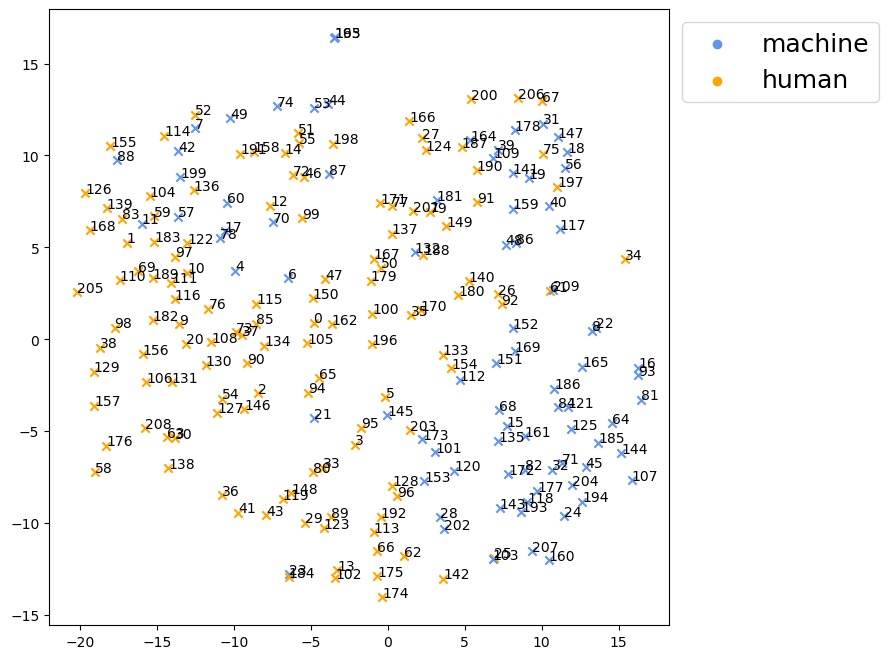

In [88]:
# original 2d positions
fig = plt.figure(figsize=(8, 8),facecolor='white')
ax = fig.add_subplot(111)
for at in atv:
    x,y = atv[at]
    plt.scatter(x,y,color=acol[at],marker='x')
    plt.annotate(str(at), (x, y))
            
for col in cola:
    plt.scatter([],[], color=col, label=cola[col])
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=18)

In [89]:
# get the boundaries of all locations
xl=50
xr=-50
yu=-50
yd=50
for a in atv:
    x,y=atv[a]
    if x<xl:
        xl=x
    if x>xr:
        xr=x
    if y<yd:
        yd=y
    if y>yu:
        yu=y

xl,xr,yu,yd

(-20.169127, 16.451687, 16.429686, -14.035293)

In [90]:
# set up gridspace
gridx=np.linspace(xl, xr, num=15)
gridy=np.linspace(yd, yu, num=14)
gridloc=[]
for x in gridx:
    for y in gridy:
        gridloc.append((x,y))
len(gridx), len(gridy), len(gridloc)

(15, 14, 210)

In [91]:
# calculate the distance from each atom to each grid node
agdis = defaultdict(lambda:defaultdict(lambda:0))
for a in atv:
    for loc in gridloc:
        agdis[a][loc]=math.sqrt((loc[0]-atv[a][0])**2+(loc[1]-atv[a][1])**2)

In [92]:
# for each grid node, assign nearest atom to it
agdis2=copy.deepcopy(agdis)
locadis={}
aloc={}
for loc in gridloc:
    dis=10000
    at=''
    for a in agdis2:
        if agdis2[a][loc] < dis:
            dis = agdis2[a][loc]
            at=a
    locadis[loc]=(at, dis)
    aloc[at]=loc
    if at != '':
        del(agdis2[at])

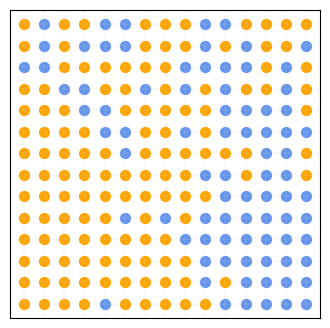

In [94]:
fig = plt.figure(figsize=(4, 4),facecolor='white')

ax = fig.add_subplot(111)
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    if locadis[loc][0] != '':
        plt.scatter(loc[0], loc[1], color=acol[locadis[loc][0]], s=50)
#plt.title("Skill Atoms",fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

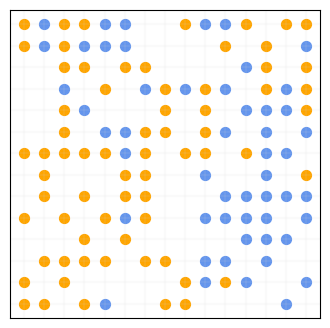

In [98]:
# empty for declining atoms
fig = plt.figure(figsize=(4, 4),facecolor='white')

ax = fig.add_subplot(111)
k=1
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    at=locadis[loc][0]
    if at != '':
        alp=ad[at]
        if alp>0: #and acol[at]=='cornflowerblue':
            plt.scatter(loc[0], loc[1], color=acol[at], s=50)
       
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/Fig_atoms_p1.pdf') 

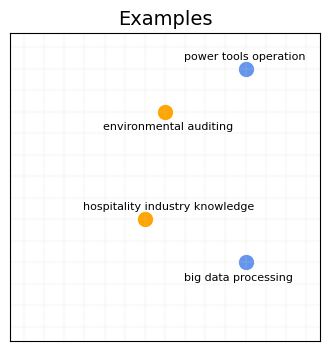

In [104]:
fig = plt.figure(figsize=(4, 4),facecolor='white')

gi={}
gi[77] = "environmental auditing"
gi[56] = "power tools operation"
gi[82] = "big data processing"
gi[105] = "hospitality industry knowledge"
ax = fig.add_subplot(111)
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for j in ['Power Plant Operators', 'Gaming Dealers']:
    ji=list(jawd[j].keys())[0]
    jd=list(jawd[j].keys())[-1]
    plt.scatter(aloc[ji][0], aloc[ji][1], color=acol[ji], s=100)
    plt.scatter(aloc[jd][0], aloc[jd][1], color=acol[jd], s=100)
    plt.text(aloc[ji][0]-8, aloc[ji][1]-2, gi[ji], fontsize=8)
    plt.text(aloc[jd][0]-8, aloc[jd][1]+1, gi[jd], fontsize=8)


plt.title("Examples",fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Save the figure
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/Fig_atoms_p2.pdf', bbox_inches='tight')

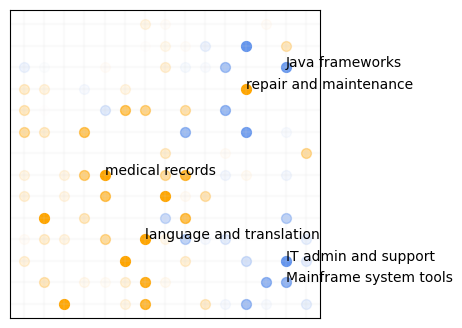

In [100]:
# declining human atoms, labeled
di={}
di[73]='medical records'
di[75]="repair and maintenance"
di[3]="language and translation"
di[144] = "IT admin and support"
di[45] = "Mainframe system tools"
di[84] = "Java frameworks"

fig = plt.figure(figsize=(4, 4),facecolor='white')
k=1
ax = fig.add_subplot(111)
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    at=locadis[loc][0]
    if at != '':
        alp=ad[at]
        if alp<0:
            plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(abs(alp*k),1),s=50)
        if at in di:
            plt.text(loc[0], loc[1], di[at], fontsize=10)
#plt.title("Decling Skill Atoms", fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Save the figure
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/Fig_atoms_p3.pdf', bbox_inches='tight')

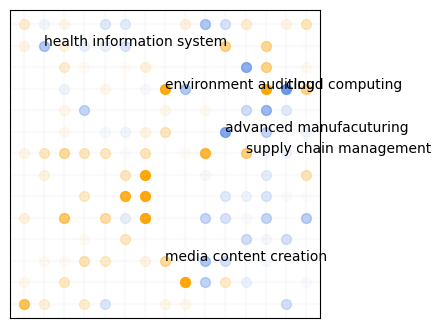

In [101]:
# rising atoms, labeled
gi2={}
gi2[121]="cloud computing"
gi2[48]="advanced manufacuturing"
gi2[7]='health information system'
gi2[128]='media content creation'
gi2[26] = 'supply chain management'
gi2[77] = "environment auditing"

fig = plt.figure(figsize=(4, 4),facecolor='white')

ax = fig.add_subplot(111)
k=1
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    at=locadis[loc][0]
    if at != '':
        alp=ad[at]
        if alp>0: #and acol[at]=='cornflowerblue':
            plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1), s=50)
        if at in gi2: #and acol[at]=='cornflowerblue':
            plt.text(loc[0], loc[1], gi2[at], fontsize=10)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Save the figure
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/Fig_atoms_p4.pdf', bbox_inches='tight')

## Supplementary Results: Job Zone

In [234]:
jz = pd.read_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/All_Job_Zones.csv')
onet_soc = pd.read_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/2019_to_SOC_Crosswalk.csv')

In [235]:
socz = {}
jzdict = dict([(i,j) for i,j in zip(jz['Occupation'], jz['Job Zone'])])
onetsocdict = dict([(i,j) for i,j in zip(onet_soc['O*NET-SOC 2019 Title'], onet_soc['2018 SOC Title'])]) 
allsocs = list(onetsocdict.values())
for j in jzdict:
    if j in onetsocdict:
        socz[onetsocdict[j]] = jzdict[j]
len(socz), len(jzdict), len(onetsocdict)

(798, 923, 1016)

In [236]:
# job zone and job skill change 
zi = defaultdict(lambda:[])
for o in socz:
    if o in jtr:
        zi[socz[o]].append(jtr[o])

for z in range(1,6):
    print(z, len(zi[z]))
zkeys = [1,2,3,4,5]
zmeans = [np.mean(zi[key]) for key in zkeys]
zstd = [calculateCI2(zi[key],'mean',50, 0.8) for key in zkeys]
xz_pos = np.arange(len(zkeys))

1 22
2 204
3 145
4 132
5 99


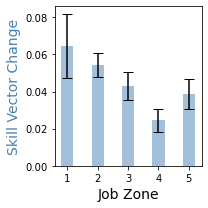

In [237]:
# figure: job zone and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax2 = fig.add_subplot(111)
f3_ax2.bar(xz_pos, zmeans, yerr=zstd, width = 0.4, color = 'steelblue', align='center', alpha=0.5, ecolor='black', capsize=5)
f3_ax2.set_ylabel('Skill Vector Change', color = 'steelblue', fontsize=14)
f3_ax2.set_xlabel('Job Zone', fontsize=14)
f3_ax2.set_xticks(xz_pos)
f3_ax2.set_xticklabels(zkeys, size=10)
f3_ax2.yaxis.set_tick_params(labelsize=10)
plt.tight_layout()
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/JobZoneSKillChange.pdf')

### Supplementary Results: Most Significant Skill Transition as Skill Change

In [ ]:
def GetNearestSkill(jys, model):
    
    jsd = defaultdict(lambda:defaultdict(lambda:''))
    n=0
    for j in jys:
        n+=1
        flushPrint(n)
        if 2010 in jys[j] and 2018 in jys[j]:
            for sn in jys[j][2018]:
                if sn in jys[j][2010]:
                    jsd[j][sn] = (0, sn)
                elif sn in model.wv:
                    dis=10000
                    ns=""
                    for so in jys[j][2010]:
                        if so in model.wv:
                            d=1-np.dot(model.wv[sn], model.wv[so])/(np.linalg.norm(model.wv[sn])* np.linalg.norm(model.wv[so]))
                            if d <= dis:
                                dis=d
                                ns=so     
                    if dis!=10000:
                        jsd[j][sn] = (dis, ns)

            jsd[j] = dict(sorted(jsd[j].items(), key=operator.itemgetter(1), reverse=True))
    
    return jsd

# max distance with different percentile criteria
def PickMaxDistance(perc, jsd):
    jmc = dict()
    for j in jsd:
        ind = max(round(len(jsd[j])*perc)-1, 0)
        sl = list(jsd[j].items())
        jmc[j] = sl[ind][1][0]
    jmc = dict(sorted(jmc.items(), key=operator.itemgetter(1), reverse=True))  
    
    return jmc

# average of skill group of max distances defined by different percentile criteria
def AvgMaxDistance(perc, jsd):
    jmc = dict()
    for j in jsd:
        ind = max(round(len(jsd[j])*perc), 1)
        sl = list(jsd[j].items())[:ind]
        jmc[j] = np.mean([e[1][0] for e in sl])
    jmc = dict(sorted(jmc.items(), key=operator.itemgetter(1), reverse=True)) 
    
    return jmc

In [ ]:
# key independent variable: skill number
def JobNSkill(dictjys):
    dictosn = {}
    for job in dictjys:
        snlst = []
        for yr in dictjys[job]:
            if len(dictjys[job][yr]) != 0:
                snlst.append(len(dictjys[job][yr]))
        if snlst:
            dictosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
    dictosn = dict(sorted(dictosn.items(), key=operator.itemgetter(1),reverse=True))
    
    return dictosn
# key depedent variable: job skill change
def JobChange(dictjys, method, perc):
    
    if method == "average":
        
        dictjyv=defaultdict(lambda:defaultdict(lambda:''))
        for j in dictjys:
            for y in dictjys[j]:
                dictjyv[j][y] = np.mean([model.wv[s] for s in dictjys[j][y] if s in model.wv], axis=0)

        dictjtr = {}
        for j in dictjyv:
            if 2010 in dictjyv[j] and 2018 in dictjyv[j]:
                if j in jyn:
                    if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                        jtrrr = np.dot(dictjyv[j][2018], dictjyv[j][2010]
                                      )/(np.linalg.norm(dictjyv[j][2018])* np.linalg.norm(dictjyv[j][2010]))
                        if type(jtrrr) == np.float32:
                            dictjtr[j] = 1 - jtrrr

        dictjtr = dict(sorted(dictjtr.items(), key=operator.itemgetter(1)))
    
    if method == "max":
        jsd=GetNearestSkill(dictjys, model)
        dictjtr = PickMaxDistance(perc, jsd)
    
    if method == "avgmax":
        jsd=GetNearestSkill(dictjys, model)
        dictjtr = AvgMaxDistance(perc, jsd)
    
    return dictjtr

In [366]:
def buildregdata(jtrwa):
    regdf=pd.DataFrame(columns = ['Occupation','SkillChange', 'LogSkillN', 'Education', 'LogPay'])
    for j in jtr:
        if j in osn and j in oe and j in op:
            regdf=regdf.append({'Occupation': j, 'SkillChange': jtrwa[j], 'LogSkillN': np.log(osn[j]),
                    'Education': oe[j], 'LogPay': np.log(op[j])}, ignore_index = True)
            
    return regdf

In [367]:
jtrm0 = JobChange(jys, "max", 0)
reg_df_max0 = buildregdata(jtrm0)

jtrm5 = JobChange(jys, "max", 0.05)
reg_df_max5 = buildregdata(jtrm5)

jtrm10 = JobChange(jys, "max", 0.10)
reg_df_max10 = buildregdata(jtrm10)

831

In [372]:
mod1= smf.ols('SkillChange ~ LogSkillN', data=reg_df_max0)
res1 = mod1.fit()

mod2= smf.ols('SkillChange ~ LogPay', data=reg_df_max0)
res2 = mod2.fit()

mod3= smf.ols('SkillChange ~ Education', data=reg_df_max0)
res3 = mod3.fit()

mod4= smf.ols('SkillChange ~ LogSkillN', data=reg_df_max5)
res4 = mod4.fit()

mod5= smf.ols('SkillChange ~ LogPay', data=reg_df_max5)
res5 = mod5.fit()

mod6= smf.ols('SkillChange ~ Education', data=reg_df_max5)
res6 = mod6.fit()

mod7= smf.ols('SkillChange ~ LogSkillN', data=reg_df_max10)
res7 = mod7.fit()

mod8= smf.ols('SkillChange ~ LogPay', data=reg_df_max10)
res8 = mod8.fit()

mod9= smf.ols('SkillChange ~ Education', data=reg_df_max10)
res9 = mod9.fit()

stargazer = Stargazer([res1, res2, res3, res4, res5, res6, res7, res8, res9])

stargazer.title('Explaining Job Skill Change Variation with Skill Complexity, Different Measures of Change')
stargazer.custom_columns(['Max', 'Max','Max','Rank 5\% ', 'Rank 5\% ','Rank 5\% ','Rank 10\% ','Rank 10\% ','Rank 10\% '], [1, 1, 1,1,1,1,1,1,1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['LogSkillN',  'LogPay', 'Education'])

stargazer.rename_covariates({'LogSkillN': 'Skill Complexity', 'LogPay': 'Log Annual Pay', 
    'Education': 'Education'})
stargazer.significance_levels([0.05, 0.01, 0.001])
#stargazer.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration).'])
stargazer

In [373]:
print(stargazer.render_html())

Explaining Job Skill Change Variation with Skill Complexity, Different Measures of Change<br><table style="text-align:center"><tr><td colspan="10" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="9"><em>Dependent variable:SkillChange</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Max</td><td colspan="1">Max</td><td colspan="1">Max</td><td colspan="1">Rank 5\% </td><td colspan="1">Rank 5\% </td><td colspan="1">Rank 5\% </td><td colspan="1">Rank 10\% </td><td colspan="1">Rank 10\% </td><td colspan="1">Rank 10\% </td></tr><tr><td colspan="10" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Skill Complexity</td><td>-0.010<sup>***</sup></td><td></td><td></td><td>-0.053<sup>***</sup></td><td></td><td></td><td>-0.062<sup>***</sup></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.002)</td><td></td><td></td><td>(0.002)</td><td></td><td></td><td>(0.002)</td><t

### Supplementary Results: Upskilling of Low-skilled Jobs towards High-skilled Jobs

In [194]:
# match to nearest occupation in the other skill group
def nearestjob(j1,j2,dis, jp, year):
    
    if j1 in jtr and j2 in jtr:
        d=1-np.dot(jyv[j1][year], jyv[j2][year])/(np.linalg.norm(jyv[j1][year])* np.linalg.norm(jyv[j2][year]))
        if d<dis:
            dis=d
            jp=j2
            
    return dis, jp

In [195]:
# skill group
def classifySkillGroup(os, jtr, cond):
    sj = defaultdict(lambda:[])
    for j in os:
        if j in jtr:
            if os[j]>=cond:
                sj['high'].append(j)
            else:
                sj['low'].append(j)  
    return sj

In [201]:
def GetPairs(skillj):
    pairs10 = defaultdict(lambda:0)
    pairs18 = defaultdict(lambda:0)
    compdict={'high':'low', 'low': 'high'}
    for g in skillj:
        for j1 in skillj[g]:
            dis10=10000
            jp10=''
            dis18=10000
            jp18=''
            for j2 in skillj[compdict[g]]:
                dis10, jp10 = nearestjob(j1,j2,dis10, jp10, 2010)
                dis18, jp18 = nearestjob(j1,j2,dis18, jp18, 2018)
            if dis10 != 10000:
                pairs10[(j1,jp10)] = dis10
            if dis18 != 10000:
                pairs18[(j1,jp18)] = dis18   
    print(len(pairs10), len(pairs18))
    
    return pairs10, pairs18

In [202]:
sj = classifySkillGroup(osn, jtr, np.median(list(osn.values())))
spairs10, spairs18 = GetPairs(sj)
np.mean(list(spairs10.values())), np.mean(list(spairs18.values())), stats.ttest_rel(list(spairs10.values()), list(spairs18.values()))

727 727


(0.0887652315824527,
 0.0661466570963066,
 Ttest_relResult(statistic=20.497855744756972, pvalue=5.033764160911014e-74))

In [219]:
cleaned_op = {}
for o in op:
    if not math.isnan(op[o]):
        cleaned_op[o]=op[o]
pj = classifySkillGroup(cleaned_op, jtr, np.median(list(cleaned_op.values())))
ppairs10, ppairs18 = GetPairs(pj)
np.mean(list(ppairs10.values())), np.mean(list(ppairs18.values())), stats.ttest_rel(list(ppairs10.values()), list(ppairs18.values()))

721 721


(0.08981245673479882,
 0.07051716275750847,
 Ttest_relResult(statistic=15.812108779937885, pvalue=1.4588509542103245e-48))

In [204]:
ej = classifySkillGroup(oe, jtr, 16)
epairs10, epairs18 = GetPairs(ej)
np.mean(list(epairs10.values())), np.mean(list(epairs18.values())), stats.ttest_rel(list(epairs10.values()), list(epairs18.values()))

721 721


(0.1356854994320175,
 0.11585051201583609,
 Ttest_relResult(statistic=14.373444578014215, pvalue=2.2703778334851705e-41))

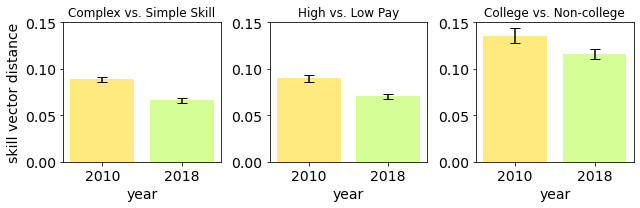

In [232]:
fig = plt.figure(figsize=(9, 3),facecolor='white')


# skill number
f1 = fig.add_subplot(131)
ymeans = [np.mean(list(spairs10.values())), np.mean(list(spairs18.values()))]
ystd = [calculateCI2(list(spairs10.values()),'mean',50, 0.8), calculateCI2(list(spairs18.values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']
f1.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'greenyellow', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.set_ylabel('skill vector distance', fontsize=14)
f1.set_xlabel('year', fontsize=14)
f1.set_xticks(xy_pos)
f1.set_xticklabels([2010, 2018],size=14)
f1.yaxis.set_tick_params(labelsize=14)
plt.title("Complex vs. Simple Skill")
plt.ylim(0,0.15)
plt.tight_layout()

# pay
f2 = fig.add_subplot(132)
ymeans = [np.mean(list(ppairs10.values())), np.mean(list(ppairs18.values()))]
ystd = [calculateCI2(list(ppairs10.values()),'mean',50, 0.8), calculateCI2(list(ppairs18.values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']
f2.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'greenyellow', align='center', alpha=0.5, ecolor='black', capsize=5)
#f2.set_ylabel('skill vector distance', fontsize=14)
f2.set_xlabel('year', fontsize=14)
f2.set_xticks(xy_pos)
f2.set_xticklabels([2010, 2018],size=14)
f2.yaxis.set_tick_params(labelsize=14)
plt.title("High vs. Low Pay")
plt.ylim(0,0.15)
plt.tight_layout()

# education
f3 = fig.add_subplot(133)
ymeans = [np.mean(list(epairs10.values())), np.mean(list(epairs18.values()))]
ystd = [calculateCI2(list(epairs10.values()),'mean',50, 0.8), calculateCI2(list(epairs18.values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']
f3.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f3.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'greenyellow', align='center', alpha=0.5, ecolor='black', capsize=5)
#f3.set_ylabel('skill vector distance', fontsize=14)
f3.set_xlabel('year', fontsize=14)
f3.set_xticks(xy_pos)
f3.set_xticklabels([2010, 2018],size=14)
f3.yaxis.set_tick_params(labelsize=14)
plt.title("College vs. Non-college")
plt.ylim(0,0.15)
plt.tight_layout()

plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/HighLowSkillGroupMoveCloser.png')

### Supplementary Results: Unemployment and Skill Change

In [375]:
# unemployment rate 2010-2018, data from BLS: unemployment_BLS.xlsx 
# (https://data.bls.gov/timeseries/LNU04023554&series_id=LNU04000000&series_id=LNU03023554&series_id=LNU03000000&years_option=all_years&periods_option=specific_periods&periods=Annual+Data)
uer1018 = [9.6, 8.9, 8.1, 7.4, 6.2, 5.3, 4.9, 4.4]
uer1018 = [u/100 for u in uer1018] 
yuer = zip(list(range(2010, 2019)), uer1018)
yuer = dict(yuer)

In [274]:
# JOB-SKILL DATA
# without filtering the skills
allyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year >= 2010 or year<=2018:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    allyjas[year][job][skill] = tfidf
                    
# job - top 5% defining skills
alljys = defaultdict(lambda:defaultdict(lambda:[]))
allsyj = defaultdict(lambda:defaultdict(lambda:[]))
for year in allyjas:
    for job in allyjas[year]:
        threshold = np.quantile(list(allyjas[year][job].values()), [0.95])
        #threshold = np.mean(list(yjas[year][job].values()))
        for skill in allyjas[year][job]:
            if allyjas[year][job][skill] > threshold:
                alljys[job][year].append(skill)
                allsyj[skill][year].append(job)
        if len(alljys[job][year]) < 5:
            #print(job, year)
            del alljys[job][year]
            fulllist = allsyj[skill][year]
            allsyj[skill][year] = [value for value in fulllist if value != job]
            
# job vector
# 200 dimension Job-Year-Vector
allyjv = defaultdict(lambda:defaultdict(lambda:''))
alljyv = defaultdict(lambda:defaultdict(lambda:''))
for j in alljys:
    for y in alljys[j]:
        alljyv[j][y] = np.mean([model.wv[s] for s in alljys[j][y] if s in model.wv],axis=0)
        allyjv[y][j] = np.mean([model.wv[s] for s in alljys[j][y] if s in model.wv],axis=0)
        #jyv[j][y] = np.sum([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

In [277]:
# job stability from 2010 to 2018: dot product between 2 job vectors
yjtr = defaultdict(lambda:defaultdict(lambda:""))
yavgc = {}
for y in range(2010, 2018):
    for j in allyjv[y]:
        if y+1 in alljyv[j] and j in jtr:
            yjtr[y][j] = 1- np.dot(alljyv[j][y], alljyv[j][y+1])/(np.linalg.norm(alljyv[j][y])* np.linalg.norm(alljyv[j][y+1]))
    yjtr[y] = dict(sorted(yjtr[y].items(), key=operator.itemgetter(1)))
    yavgc[y] = np.mean(list(yjtr[y].values())) 

yjtr = dict(sorted(yjtr.items(), key=operator.itemgetter(0)))
yavgc = dict(sorted(yavgc.items(), key=operator.itemgetter(0)))

In [294]:
yavgc

{2010: 0.02766351270082906,
 2011: 0.02484441602098349,
 2012: 0.025479415067299668,
 2013: 0.020749672816904898,
 2014: 0.01940603728471465,
 2015: 0.019610293968978336,
 2016: 0.01792257761495501,
 2017: 0.01794984940813529}

In [377]:
print(pearsonr(uer1018, list(yavgc.values())))

(0.9498244720541461, 0.0003040377992264039)


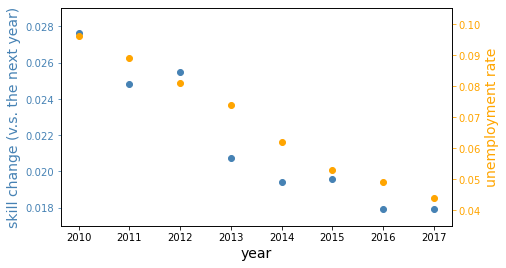

In [307]:
# Create the first set of scatter plots (aligned with the left axes)
fig, ax1 = plt.subplots(figsize=(7, 4),facecolor='white')
x, y1 =zip(*yavgc.items())
ax1.scatter(x, y1, color='steelblue')
ax1.set_ylim(0.017, 0.029)
ax1.tick_params(axis='y', labelcolor='steelblue', color='steelblue')


# Create the second set of scatter plots (aligned with the right axes)
ax2 = ax1.twinx()
x, y2 =zip(*yuer.items())
ax2.scatter(x, y2, color='orange')
ax2.set_ylim(0.035, 0.105)
ax2.tick_params(axis='y', labelcolor='orange', color='orange')

# Customize the plots
ax1.set_xlabel('year', fontsize=14)
ax1.set_ylabel('skill change (v.s. the next year)', color='steelblue', fontsize=14)
ax2.set_ylabel('unemployment rate', color='orange', fontsize=14)
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/uerskillchange.png')
plt.show()

### Supplementary Results: Re-educational Cost Reflected by Occupational Skill Change

In [64]:
SocSmSnEdudSvd = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:[])))
SocSmSnEdudSvdAll = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:[])))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/SocSnSaddEdudSvd_10perc821seed.txt', 'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        if float(line_lst[3])>0:
            SocSmSnEdudSvd[line_lst[0]][int(line_lst[1])][int(line_lst[2])].append([float(k) for k in line_lst[3:]])
        SocSmSnEdudSvdAll[line_lst[0]][int(line_lst[1])][int(line_lst[2])].append([float(k) for k in line_lst[3:]])

In [65]:
len(SocSmSnEdudSvd), len(SocSmSnEdudSvdAll)

(448, 652)

#### Number of added skill distribution of occupation

In [66]:
SocAddN = defaultdict(lambda:defaultdict(lambda:0))
SocAddNlst = defaultdict(lambda:[])
AddN=defaultdict(lambda:0)
for occ in SocSmSnEdudSvd:
    for m in SocSmSnEdudSvd[occ]:
        for n in SocSmSnEdudSvd[occ][m]:
            SocAddN[occ][n-m]+=len(SocSmSnEdudSvd[occ][m][n])
            AddN[n-m]+=len(SocSmSnEdudSvd[occ][m][n])
            SocAddNlst[occ]+=[n-m]*len(SocSmSnEdudSvd[occ][m][n])
    SocAddN[occ] = dict(sorted(SocAddN[occ].items(), key=operator.itemgetter(1), reverse=True))
AddN=dict(sorted(AddN.items(), key=operator.itemgetter(1), reverse=True))    

(0.0, 50.0)

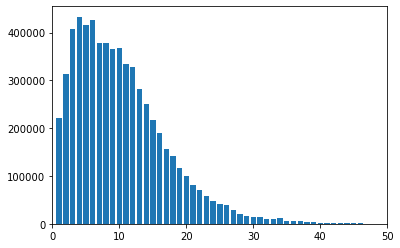

In [67]:
plt.bar(list(AddN.keys()), list(AddN.values()))
plt.xlim(0, 50)

In [68]:
# find occupations, get density plot peak for each occupation
AddnSoc=defaultdict(lambda:defaultdict(lambda:0))
socpeak={}
for occ in SocAddNlst:
    data = SocAddNlst[occ]
    if len(set(data))==1:
        an=data[0]
    else:
        plot=sns.kdeplot(data)
        kde_data = plot.get_lines()[0].get_data()
        kde_x, kde_y = kde_data
        an=round(kde_x[np.argmax(kde_y)])
        plt.clf()
        if an not in SocAddN[occ]:
            dis=10000
            for n in SocAddN[occ]:
                if abs(n-kde_x[np.argmax(kde_y)]) <= dis:
                    dis = abs(n-kde_x[np.argmax(kde_y)])
                    an=n 
            
    socpeak[occ] = an
    AddnSoc[an][occ] = SocAddN[occ][an]

for addn in AddnSoc:
    AddnSoc[addn] = dict(sorted(AddnSoc[addn].items(), key=operator.itemgetter(1), reverse=True))
AddnSoc = dict(sorted(AddnSoc.items(), key=operator.itemgetter(0)))

<Figure size 432x288 with 0 Axes>

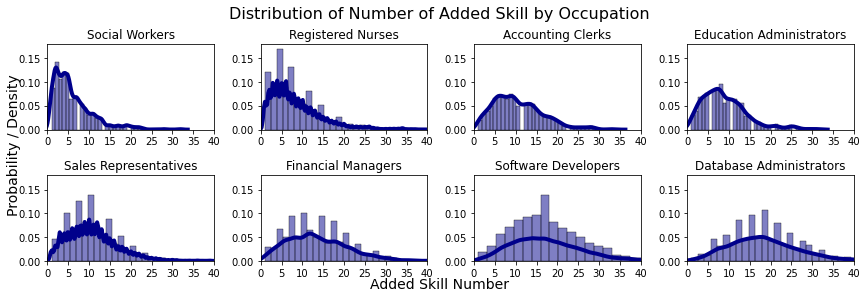

In [99]:
# 4*2 figure
occupations = ['Social Workers, All Other', 'Registered Nurses',
         'Bookkeeping, Accounting, and Auditing Clerks','Education Administrators, Postsecondary',
       'Sales Representatives, Wholesale and Manufacturing, Except Technical and Scientific Products',
            'Financial Managers', 'Software Developers, Applications','Database Administrators']
labels={'Preschool Teachers, Except Special Education': 'Preschool Teachers',
        'Social Workers, All Other': 'Social Workers',
        'Education Administrators, Postsecondary': 'Education Administrators',
        'Bookkeeping, Accounting, and Auditing Clerks': 'Accounting Clerks',
        'Software Developers, Applications':'Software Developers',
       'Sales Representatives, Wholesale and Manufacturing, Except Technical and Scientific Products': 'Sales Representatives'}

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,4))
fig.patch.set_facecolor('white')
fig.suptitle("Distribution of Number of Added Skill by Occupation", fontsize=16)

# Add x and y labels for the entire figure
fig.text(0.5, 0.0000001, 'Added Skill Number', ha='center', fontsize=14)
fig.text(0.000000001, 0.5, 'Probability / Density', va='center', rotation='vertical', fontsize=14)
for i, occ in enumerate(occupations):
    row, col = divmod(i, 4)
    data = SocAddNlst[occ]
    if occ in list(labels.keys()):
        label =labels[occ]
    else:
        label=occ
    ax = axes[row, col]
    ax.set_title(label)
    
    # histogram
    sns.histplot(data, bins=int(180/5), stat='probability', color='darkblue', edgecolor='black', 
                 alpha=0.5, ax=ax)
    # Add KDE
    plot=sns.kdeplot(data, color='darkblue', linewidth=4, label='KDE', ax=ax)
    # Set the x and y lim and ticks
    custom_xticks = list(range(0, 41, 5))
    ax.set(xticks=custom_xticks)
    ax.set_xlim(0, 40)
    ax.set_ylim(0, 0.18)
    ax.set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/AddedSkillDistribution_10perc821seed.png')
plt.show()


#### Figure S10. Education Cost of Marginal Skill Vector Distance between Jobs

In [137]:
osvdedud = []
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/osvdedud_10perc821seed.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        osvdedud.append((float(linelst[0]), float(linelst[1])))

# education distance and skill distance
svd, edud = zip(*osvdedud)
z_scores = np.array(svd)
z_scores = (z_scores - z_scores.mean()) / z_scores.std()
ze = list(zip(z_scores, edud))
sci = defaultdict(lambda:[])
for s,e in ze:
    if s < -1:
        sci["<-1SD"].append(e)
    elif -1 <= s <= 1:
        sci["-1SD - +1SD"].append(e)
    else:
        sci[">+1SD"].append(e)

sckeys = ["<-1SD", "-1SD - +1SD", ">+1SD"]
scmeans = [np.mean(sci[key]) for key in sckeys]
scstd = [calculateCI2(sci[key],'mean',50, 0.8) for key in sckeys]
xsc_pos = np.arange(len(sckeys))

In [138]:
# correlation between skill distance and education difference
x, y = zip(*osvdedud)
spearmanr(x, y), pearsonr(x, y)

(SignificanceResult(statistic=0.13521232405663985, pvalue=1.5003825443311588e-06),
 PearsonRResult(statistic=0.14572700957545745, pvalue=2.1117882711418665e-07))

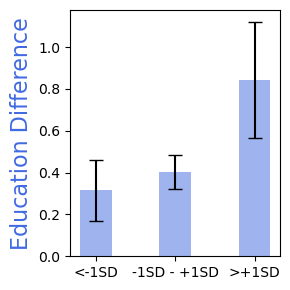

In [139]:
fig = plt.figure(figsize=(3, 3),facecolor='white')
f3_ax2 = fig.add_subplot(111)
f3_ax2.bar(xsc_pos, scmeans, yerr=scstd, width=0.4, color = 'royalblue', align='center', alpha=0.5, ecolor='black', capsize=5)
#f3_ax2.set_xlabel('Skill Vector Distance', color = 'royalblue', fontsize=14)
f3_ax2.set_ylabel('Education Difference', color = 'royalblue', fontsize=16)
#f3_ax2.set_xlabel('Education Change', fontsize=14)
f3_ax2.set_xticks(xsc_pos)
f3_ax2.set_xticklabels(sckeys, size=10)
f3_ax2.yaxis.set_tick_params(labelsize=10)
plt.tight_layout()

plt.savefig('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/Results/updated/SI/edudifskilldis.pdf')

#### Skill distance and education difference

In [71]:
# data
svdedud = []
osvdedud = []
socs=defaultdict(lambda:0)
#select the peak with +-1 slide window for each occupation
for occ in SocSmSnEdudSvdAll:
    if occ in socpeak:
        add=[socpeak[occ], socpeak[occ]-1, socpeak[occ]+1]
        osvdedudlst=defaultdict(lambda:[])
        for sm in SocSmSnEdudSvdAll[occ]:
            for sn in SocSmSnEdudSvdAll[occ][sm]:
                if sn-sm in add:
                    for unit in SocSmSnEdudSvdAll[occ][sm][sn]:
                        svdedud.append((unit[1], unit[0]))
                        osvdedudlst[sn-sm].append((unit[1], unit[0]))
                        socs[occ]+=1

        for n in osvdedudlst:
            osvdedud.append(tuple([sum(t) / len(osvdedudlst[n]) for t in zip(*osvdedudlst[n])]))
# all instances
len(svdedud), len(socs), len(osvdedud)

(6585524, 448, 1257)

In [73]:
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/svdedud_10perc821seed.txt', 'w') as f:
    for svd, edud in svdedud:
        line="\t".join([str(svd), str(edud)])
        f.write(line+'\n')
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/osvdedud_10perc821seed.txt', 'w') as f:
    for osvd, edud in osvdedud:
        line="\t".join([str(osvd), str(edud)])
        f.write(line+'\n')

In [186]:
osvdedud = []
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/osvdedud_10perc821seed.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        osvdedud.append((float(linelst[0]), float(linelst[1])))
svdedud = []
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/svdedud_10perc821seed.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        svdedud.append((float(linelst[0]), float(linelst[1])))

In [187]:
# post level correlation
x, y = zip(*svdedud)
spearmanr(x, y), pearsonr(x, y)

(SpearmanrResult(correlation=0.0550634213908414, pvalue=0.0),
 (0.041796178792241186, 0.0))

In [227]:
# occupation average level correlation
# post level correlation
x, y = zip(*osvdedud)
spearmanr(x, y), pearsonr(x, y)

(SpearmanrResult(correlation=0.13521232405663985, pvalue=1.5003825443311582e-06),
 (0.14572700957545776, 2.111788271143556e-07))

In [229]:
# put variables in a dataframe
reg_df=pd.DataFrame(columns = ["SkillDistance", "EduDifference"])
xs, ys = zip(*svdedud)
reg_df["SkillDistance"]=xs
reg_df["EduDifference"]=ys
len(reg_df)

6585524

In [228]:
oreg_df=pd.DataFrame(columns = ["SkillDistance", "EduDifference", "ZSkillDistance"])

# post level z-score regression
x, y = zip(*osvdedud)
z_scores = np.array(x)
z_scores = (z_scores - z_scores.mean()) / z_scores.std()

oreg_df["SkillDistance"]=x
oreg_df["EduDifference"]=y
oreg_df["ZSkillDistance"]=z_scores
len(oreg_df)

1257

In [230]:
resf1 =  smf.ols("EduDifference ~ SkillDistance", data=reg_df).fit()
resf2 =  smf.ols("EduDifference ~ SkillDistance", data=oreg_df).fit()
resf3 =  smf.ols("EduDifference ~ ZSkillDistance", data=oreg_df).fit()

stargazerf = Stargazer([resf1, resf2, resf3])

stargazerf.title('Predicting Education Year Difference with Skill Distance')
stargazerf.custom_columns(['Job Post Unit', 'Occupation Aggregated Unit', 'Occupation Aggregated Unit'], [1, 1, 1])
stargazerf.show_model_numbers(False)
stargazerf.covariate_order(['SkillDistance', 'ZSkillDistance'])
stargazerf.rename_covariates({'SkillDistance': 'Skill Distance', 'ZSkillDistance': 'Skill Distance Z-score'})
stargazerf.significance_levels([0.05, 0.01, 0.001])
stargazerf

In [241]:
print(stargazerf.render_html())

Predicting Education Year Difference with Skill Distance<br><table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable:EduDifference</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Job Post Unit</td><td colspan="1">Occupation Aggregated Unit</td><td colspan="1">Occupation Aggregated Unit</td></tr><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Skill Distance</td><td>0.741<sup>***</sup></td><td>1.839<sup>***</sup></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.007)</td><td>(0.352)</td><td></td></tr><tr><td style="text-align:left">Skill Distance Z-score</td><td></td><td></td><td>0.172<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.033)</td></tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: 

#### Numbers used in examples

In [84]:
# z-score for the skill distance in the job pair example
x, y = zip(*osvdedud)
z_scores = np.array(x)
(0.17 - z_scores.mean()) / z_scores.std()

-1.132695001448084

In [91]:
# skill change of high and low education group
hc = []
lc = []
for j in jtr:
    if j in oe:
        if oe[j]>=16:
            hc.append(jtr[j])
        else:
            lc.append(jtr[j])
# skill change, predicted educational cost
print(np.mean(hc), np.mean(lc), np.mean(hc)*1.84, np.mean(lc)*1.84)

0.031813181486705804 0.0483680062152289 0.05853625393553868 0.08899713143602118


In [92]:
# high pay and low pay jobs' skill change
hp=[]
lp=[]
plist = [x for x in list(op.values()) if math.isnan(x) == False]
for j in jtr:
    if j in op:
        if op[j] >= np.quantile(plist, [0.75]):
            hp.append(jtr[j])
        elif op[j] < np.quantile(plist, [0.25]):
            lp.append(jtr[j])
print(np.mean(hp), np.mean(lp), np.mean(hp)*1.84, np.mean(lp)*1.84)

0.033671291974874645 0.0502329600805586 0.06195517723376935 0.09242864654822783


In [93]:
# schooling cost from community college: https://educationdata.org/average-cost-of-community-college
0.06*2055*2, 0.09*2055*2

(246.6, 369.9)

In [94]:
# computer programmer and food batchmaker: skill change, predicted education change, predicted schooling cost
print(jtr['Food Batchmakers'], jtr["Computer Programmers"], jtr['Food Batchmakers']*1.84, jtr["Computer Programmers"]*1.84, jtr['Food Batchmakers']*1.84*2055*2, jtr["Computer Programmers"]*1.84*2055*2)

0.08175450563430786 0.01701796054840088 0.15042829036712646 0.03131304740905762 618.2602734088897 128.6966248512268


## Supplementary Results: robustness checks
#### (1) control for employer concentration, within-occupation job role homogeneity, and its changes
#### (2) different job content scope with skill weights

In [ ]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

In [ ]:
def weighted_change_coreskill(dictyjas, quant, var):
    
    if quant == 0:
        yjas2=yjas
    else:
        # filter the defining skills
        yjas2 = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
        for year in dictyjas:
            for job in dictyjas[year]:
                threshold = np.quantile(list(dictyjas[year][job].values()), [quant])
                for skill in dictyjas[year][job]:
                    if dictyjas[year][job][skill] >= threshold:
                        yjas2[year][job][skill] = dictyjas[year][job][skill]
                    
    jycsw = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
    for yr in yjas2:
        for j in yjas2[yr]:
            freqsum=np.sum(list(yjas2[yr][j].values()))
            for s in yjas2[yr][j]:
                jycsw[j][yr][s] = yjas2[yr][j][s] / freqsum   
    
    # 200 dimension Job-Year-Vector
    jyv_w2 = defaultdict(lambda:defaultdict(lambda:''))
    for j in jycsw:
        for y in jycsw[j]:
            jyv_w2[j][y] = np.sum([model.wv[s]*jycsw[j][y][s] for s in jycsw[j][y].keys() if s in model.wv],axis=0)
    
    # job change from 2010 to 2018: 1 - dot product between 2 job vectors
    jtr_w2 = {}
    for j in jyv_w2:
        if 2010 in jyv_w2[j] and 2018 in jyv_w2[j]:
            if var == "occ":
                if j in jyn:
                    # retain jobs with more than 100 posts in both 2010 and 2018
                    if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                        jtr_w2[j] = 1- np.dot(jyv_w2[j][2018], jyv_w2[j][2010])/(
                            np.linalg.norm(jyv_w2[j][2018])* np.linalg.norm(jyv_w2[j][2010]))
            else:
                jtr_w2[j] = 1- np.dot(jyv_w2[j][2018], jyv_w2[j][2010])/(
                            np.linalg.norm(jyv_w2[j][2018])* np.linalg.norm(jyv_w2[j][2010]))

    jtr_w2 = dict(sorted(jtr_w2.items(), key=operator.itemgetter(1)))
    
    return jtr_w2

### occupation unit regressions: low-skilled occupations change more

In [ ]:
### read in data

# JOB YEAR NPOSTS
jyn = defaultdict(lambda:defaultdict(lambda:0))
yjn = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_socName_Nposts_aveMedianPay_aveMinEdu.txt','r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        year = int(line_lst[0])
        job = line_lst[1]
        num = int(line_lst[2])
        if year in [2010, 2018]:
            jyn[job][year] = num
            yjn[year][job] = num

jn = {}
for j in jyn:
    jn[j] = round(np.mean(list(jyn[j].values())))

# soc - pay - education
oe={}
op={}
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/socName_aveMedianPay_aveMinEdu_socGroup.txt','r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        job = line_lst[0]
        op[job] = float(line_lst[1])
        oe[job] = float(line_lst[2])

# JOB-SKILL DATA
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    yjas[year][job][skill] = tfidf
                    
# job - top 5% defining skills
jys = defaultdict(lambda:defaultdict(lambda:[]))
for year in yjas:
    for job in yjas[year]:
        threshold = np.quantile(list(yj
                                     as[year][job].values()), [0.95])
        for skill in yjas[year][job]:
            if yjas[year][job][skill] > threshold:
                jys[job][year].append(skill)
        if len(jys[job][year]) < 5:
            del jys[job][year]
            
# job - SKILL NUMBER
osn = {}
for job in jys:
    snlst = []
    for yr in jys[job]:
        if len(jys[job][yr]) != 0:
            snlst.append(len(jys[job][yr]))
    if snlst:
        osn[job] = round(np.mean(snlst)) 
osn = dict(sorted(osn.items(), key=operator.itemgetter(1),reverse=True))

# job vector
# 200 dimension Job-Year-Vector
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    for y in jys[j]:
        jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        
# job stability from 2010 to 2018: dot product between 2 job vectors
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

# generate job change data of different skill content scope with weights
jtrwa = weighted_change_coreskill(yjas, 0, "occ")
jtrwa50 = weighted_change_coreskill(yjas, 0.5, "occ")
jtrwa75 = weighted_change_coreskill(yjas, 0.75, "occ")

# occupation homogeneity: Average occupation with random 5% sample
occ_year_sim5 = defaultdict(lambda:defaultdict(lambda:[]))
for year in [2010, 2018]:
    with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/'+str(year)+'_occ_5percsamp_occavgsim.txt', 'r') as f:
        for line in f:
            key = line.split('\t')[0]
            if key in jtr:
                occ_year_sim5[key][year].append(float(line.split('\t')[1]))


# average homogeneity score, homogeneity score change
occ_avgsim5 = {}
occ_simch5 = {}
for key in occ_year_sim5:
    if 2010 in occ_year_sim5[key] and 2018 in occ_year_sim5[key]:
        avgsim10 = np.mean(occ_year_sim5[key][2010])
        avgsim18 = np.mean(occ_year_sim5[key][2018])
        occ_avgsim5[key]=np.mean([avgsim10, avgsim18])
        occ_simch5[key] = avgsim18 - avgsim10

# occupation employer concentration
occ_yr_ec = defaultdict(lambda:[])
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_occ_cz_empcon.txt', 'r') as f1:
    for line in f1:
        line_lst = line.split('\t')
        year = int(line_lst[0])
        if year == 2010 or year == 2018:
            ec = float(line_lst[3])
            if not np.isnan(ec):
                occ_yr_ec[line_lst[1]].append(ec)
# avg employer concentration
occ_avgec=defaultdict(lambda:0)
for occ in occ_yr_ec:
    occ_avgec[occ] = np.mean(occ_yr_ec[occ])

In [ ]:
### construct regression df with weights

rows = []  # Collect rows to add as a list of dictionaries
for j in jtr:
    if (j in occ_avgsim5 and j in occ_simch5 and j in occ_avgec and j in jn and j in oe and j in op and j in osn):
        # Extract the unit size as weights
        replication_count = int(jn[j])
        # Create the row dictionary
        row = {'Occupation': j, 'SkillChange': jtr[j], "LogSkillN": np.log(osn[j]), "LogPay":np.log(op[j]), 
            'Education': oe[j], 'EmployerConcentration': np.log(occ_avgec[j]),
            'JobHomogeneity': occ_avgsim5[j], 'JobHomogeneityChange': occ_simch5[j],
            'WeightedSkillChange': jtrwa[j], 'WeightedSkillChange50': jtrwa50[j], 
            'WeightedSkillChange75': jtrwa75[j]}
        
        # Replicate the row and add to the list to weight
        rows.extend([row] * replication_count)

# Convert the collected rows to a DataFrame
regdf = pd.DataFrame(rows)

In [ ]:
# Table S4: regression control for employer concentration, job role homogeneity and its changes

res1 = smf.ols('SkillChange ~ LogSkillN', data=regdf).fit()
res2= smf.ols('SkillChange ~ Education', data=regdf).fit()
res3= smf.ols('SkillChange ~ LogPay', data=regdf).fit()
res4= smf.ols('SkillChange ~ LogSkillN + EmployerConcentration + JobHomogeneityChange + JobHomogeneity', data=regdf).fit()
res5 = smf.ols('SkillChange ~ Education + EmployerConcentration + JobHomogeneityChange + JobHomogeneity', data=regdf).fit()
res6= smf.ols('SkillChange ~ LogPay + EmployerConcentration + JobHomogeneityChange + JobHomogeneity', data=regdf).fit()

stargazer = Stargazer([res1, res3, res2, res4, res6, res5])

stargazer.title('Explaining Job Skill Change Variation with Skill Complexity')
stargazer.custom_columns(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'], [1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['LogSkillN', 'LogPay', 'Education', 'EmployerConcentration',
                           'JobHomogeneityChange', 'JobHomogeneity'])

stargazer.rename_covariates({'LogSkillN': 'Skill Complexity', 'LogPay': 'Log Annual Pay', 
    'Education': 'Education', 'EmployerConcentration': 'Log Emp. Concentr.', 
    'JobHomogeneityChange': 'Job Similarity Increase', 'JobHomogeneity': 'Job Similarity'})
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration). Job similarity measures how similar  job posts are within the same occupation in a given year. Job Similarity Increase measures within-occupation job role compositional change.'])

In [ ]:
# Table S7: different job content scope and skill weights

res1= smf.ols('WeightedSkillChange ~ LogSkillN + EmployerConcentration + JobHomogeneityChange + JobHomogeneity', data=regdf).fit()
res2= smf.ols('WeightedSkillChange50 ~ LogSkillN + EmployerConcentration + JobHomogeneityChange + JobHomogeneity', data=regdf).fit()
res3= smf.ols('WeightedSkillChange75 ~ LogSkillN + EmployerConcentration + JobHomogeneityChange + JobHomogeneity', data=regdf).fit()

stargazer = Stargazer([res1, res2, res3])

stargazer.title('Explaining Job Skill Change Variation with Skill Complexity, Different Job Content Scope and Skill Weights')
stargazer.custom_columns(['All Skills', 'Top 50\% Skills', 'Top 25\% Skills'], [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['LogSkillN', 'EmployerConcentration','JobHomogeneityChange','JobHomogeneity'])

stargazer.rename_covariates({'LogSkillN': 'Skill Complexity',
            'EmployerConcentration': 'Log Emp. Concentr.',
   'JobHomogeneityChange': 'Job Similarity Increase', 'JobHomogeneity': 'Job Similarity'})
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration). Job similarity measures how similar  job posts are within the same occupation in a given year. Job Similarity Increase measures within-occupation job role compositional change.'])

### firm-commuting zone-occupation unit regressions: small firms and markets change more

In [ ]:
### read in data

# JOB-SKILL DATA
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
jy = defaultdict(lambda:set())
for year in [2010, 2018]:
    with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/'+str(year)+'_comp_cz_occ_skill_freq.txt', 'r') as f:
        for line in f:
            line_lst = line.split("\t")
            key = (line_lst[0], line_lst[1], line_lst[2])
            skills = line_lst[3:]
            if len(skills) > 5:
                for skill_freq in skills:
                    skill = skill_freq.split('_')[0].lower()
                    freq = float(skill_freq.split('_')[1])
                    yjas[year][key][skill] = freq
                    jy[key].add(year)

for j in jy:
    if len(jy[j]) != 2:
        year = list(jy[j])[0]
        del yjas[year][j]

jys = defaultdict(lambda:defaultdict(lambda:[]))
for year in yjas:
    for job in yjas[year]:
        threshold = np.quantile(list(yjas[year][job].values()), [0.95])
        ss = [skill for skill in yjas[year][job] if yjas[year][job][skill] > threshold]
        if len(ss) >= 5:
            jys[job][year] = ss

# 200 dimension Job-Year-Vector
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    if 2010 in jys[j] and 2018 in jys[j]:
        for y in jys[j]:
            jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)


# job change from 2010 to 2018
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

# generate job change data of different skill content scope with weights
jtrwa75 = weighted_change_coreskill(yjas, 0.75, "compczocc")
jtrwa50 = weighted_change_coreskill(yjas, 0.5, "compczocc")
jtrwa = weighted_change_coreskill(yjas, 0, "compczocc")

# firm-cz-occupation homogeneity
compczocc_year_stats = defaultdict(lambda:defaultdict(lambda:()))
for year in [2010, 2018]:
    with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/'+str(year)+'_comp_cz_occ_sampsize_occavgsim.txt', 'r') as f:
        for line in f:
            key = (line.split('\t')[0], line.split('\t')[1], line.split('\t')[2])
            if key in jtrwa:
                compczocc_year_stats[key][year] = (int(line.split('\t')[3]), float(line.split('\t')[4]))

# average homogeneity score and sample size, homogeneity score change
compczocc_avgstats = {}
compczocc_simch = {}
for key in compczocc_year_stats:
    if 2010 in compczocc_year_stats[key] and 2018 in compczocc_year_stats[key]:
        avgsize=np.mean([compczocc_year_stats[key][2010][0], compczocc_year_stats[key][2018][0]])
        avgsim=np.mean([compczocc_year_stats[key][2010][1], compczocc_year_stats[key][2018][1]])
        compczocc_avgstats[key] = (round(avgsize), avgsim)
        compczocc_simch[key] = compczocc_year_stats[key][2018][1] - compczocc_year_stats[key][2010][1]

# cz-occupation employer concentration
occcz_yr_ec = defaultdict(lambda:[])
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_occ_cz_empcon.txt', 'r') as f1:
    for line in f1:
        line_lst = line.split('\t')
        year = int(line_lst[0])
        if year == 2010 or year == 2018:
            ec = float(line_lst[3])
            if not np.isnan(ec):
                occcz_yr_ec[(line_lst[1], line_lst[2])].append(ec)

# avg employer concentration
occcz_avgec=defaultdict(lambda:0)
for occcz in occcz_yr_ec:
    occcz_avgec[occcz] = np.mean(occcz_yr_ec[occcz])

# firm and cz size
comp_yrsize=defaultdict(lambda:defaultdict(lambda:0))
cz_yrsize=defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_comp_cz_occ_size_compsize_czsize.txt', 'r') as f1:
    for line in f1:
        line_lst = line.split('\t')
        year = int(line_lst[0])
        comp_yrsize[line_lst[1]][year] += int(line_lst[4])
        cz_yrsize[line_lst[2]][year] += int(line_lst[4])

def CalculateSize(compczocc_yrsize):
    # average unit size
    compczocc_avgsize=defaultdict(lambda:0)
    for compczocc in compczocc_yrsize:
        compczocc_avgsize[compczocc] = np.mean(list(compczocc_yrsize[compczocc].values()))
    return compczocc_avgsize
# firm, sample with non-missing occupation
comp_avgsize = CalculateSize(comp_yrsize)
# cz, sample with non-missing occupation
cz_avgsize = CalculateSize(cz_yrsize)

In [ ]:
### construct regression df
rows = []  # Collect rows to add as a list of dictionaries
for j in jtr:
    if (j in compczocc_avgstats and j in compczocc_simch and (j[0], j[1]) in compcz_avgsize):
        # Extract the unit size
        replication_count = int(compczocc_avgstats[j][0])
        # Create the row dictionary
        row = {'Employer': j[0], 'Market': j[1], 'Occupation': j[2], 'SkillChange': jtr[j],
        'LogUnitSize': np.log(compcz_avgsize[(j[0], j[1])]), 'LogEmployerSize': np.log(comp_avgsize[j[0]]),
        'LogMarketSize': np.log(cz_avgsize[j[1]]), 'JobHomogeneity': compczocc_avgstats[j][1], 
               'JobHomogeneityChange': compczocc_simch[j],'EmployerConcentration': np.log(occcz_avgec[(j[2], j[1])])}
        
        # Replicate the row and add to the list to weight
        rows.extend([row] * replication_count)

# Convert the collected rows to a DataFrame
regdf = pd.DataFrame(rows)

In [ ]:
# Table S5. within firm-region-occupation change

resf1 =  smf.ols("SkillChange ~ LogEmployerSize + C(Occupation)", data=regdf).fit()
resf2 =  smf.ols("SkillChange ~ LogMarketSize + C(Occupation)", data=regdf).fit()
resf3 =  smf.ols("SkillChange ~ LogEmployerSize + LogMarketSize + C(Occupation)+ EmployerConcentration + JobHomogeneityChange", data=regdf).fit()

stargazerf = Stargazer([resf1, resf2, resf3])

stargazerf.title('Explaining Job Skill Change Variation with Employer and Market size')
stargazerf.custom_columns(['Model 1', 'Model 2', 'Model 3'], [1, 1, 1])
stargazerf.show_model_numbers(False)

stargazerf.covariate_order(['LogEmployerSize', 'LogMarketSize','EmployerConcentration', 
                            'JobHomogeneityChange'])
stargazerf.rename_covariates({'LogEmployerSize': 'Employer Size', 'LogMarketSize': 'CZ Market Size', 
                'EmployerConcentration': 'Log Emp. Concentr.', 
                'JobHomogeneityChange': 'Job Similarity Increase'})
stargazerf.significance_levels([0.05, 0.01, 0.001])
stargazerf.add_line('Occ. FE', ['Yes', 'Yes', 'Yes'])
stargazerf.add_custom_notes(['CZ refers to commuting zone. Log Emp. Concentr. refers to the natural log of HHI (employer concentration). Job similarity measures how similar  job posts are within the same occupation in a given year. Job Similarity Increase measures within-occupation job role compositional change.'])

In [ ]:
### construct regression df: different job content scope and skill weights 
rows = []  # Collect rows to add as a list of dictionaries
for j in jtrwa:
    if (j in compczocc_avgstats and j in compczocc_simch and (j[0], j[1]) in compcz_avgsize):
        # Extract the unit size as weight
        replication_count = int(compczocc_avgstats[j][0])
        
        # Create the row dictionary
        row = {'Employer': j[0], 'Market': j[1], 'Occupation': j[2],
        'LogUnitSize': np.log(compcz_avgsize[(j[0], j[1])]), 'LogEmployerSize': np.log(comp_avgsize[j[0]]),
        'LogMarketSize': np.log(cz_avgsize[j[1]]), 'JobHomogeneity': compczocc_avgstats[j][1], 'JobHomogeneityChange': compczocc_simch[j],
        'EmployerConcentration': np.log(occcz_avgec[(j[2], j[1])]), 'WeightedSkillChange': jtrwa[j], 'WeightedSkillChange50': jtrwa50[j], 
        'WeightedSkillChange75': jtrwa75[j]}
        
        # Replicate the row and add to the list to weight
        rows.extend([row] * replication_count)
# Convert the collected rows to a DataFrame
regdf = pd.DataFrame(rows)

In [ ]:
# Table S8. different job content scope and skill weights

resf1 =  smf.ols("WeightedSkillChange ~ LogEmployerSize + LogMarketSize + C(Occupation)+ EmployerConcentration + JobHomogeneityChange", data=regdf).fit()
resf2 =  smf.ols("WeightedSkillChange50 ~ LogEmployerSize + LogMarketSize + C(Occupation)+ EmployerConcentration + JobHomogeneityChange", data=regdf).fit()
resf3 =  smf.ols("WeightedSkillChange75 ~ LogEmployerSize + LogMarketSize + C(Occupation)+ EmployerConcentration + JobHomogeneityChange", data=regdf).fit()

stargazerf = Stargazer([resf1, resf2, resf3])

stargazerf.title('Explaining Job Skill Change Variation with Organization and Local Market Size, Different Job Content Scope and Skill Weights')
stargazerf.custom_columns(['All Skills', 'Top 50\% Skills', 'Top 25\% Skills'], [1, 1, 1])
stargazerf.show_model_numbers(False)

stargazerf.covariate_order(['LogEmployerSize', 'LogMarketSize','EmployerConcentration', 
                            'JobHomogeneityChange'])
stargazerf.rename_covariates({'LogEmployerSize': 'Employer Size', 'LogMarketSize': 'CZ Market Size', 
            'EmployerConcentration': 'Log Emp. Concentr.', 
            'JobHomogeneityChange': 'Job Similarity Increase'})
stargazerf.significance_levels([0.05, 0.01, 0.001])
stargazerf.add_line('Occ. FE', ['Yes', 'Yes', 'Yes'])
stargazerf.add_custom_notes(['CZ refers to commuting zone. Log Emp. Concentr. refers to the natural log of HHI (employer concentration). Job similarity measures how similar  job posts are within the same occupation in a given year. Job Similarity Increase measures within-occupation job role compositional change.'])

### firm-commuting zone unit regressions: small firms and markets change more

In [ ]:
### read in data

# JOB-SKILL DATA
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
jy = defaultdict(lambda:set())
for year in [2010, 2018]:
    with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/'+str(year)+'_comp_cz_occ_skill_freq.txt', 'r') as f:
        n=0
        for line in f:
            n+=1
            if n % 10000 == 0:
                flushPrint(n)
            line_lst = line.split("\t")
            key = (line_lst[0], line_lst[1])
            skills = line_lst[3:]
            if len(skills) > 5:
                for skill_freq in skills:
                    skill = skill_freq.split('_')[0].lower()
                    freq = float(skill_freq.split('_')[1])
                    yjas[year][key][skill] += freq
                    jy[key].add(year)

for j in jy:
    if len(jy[j]) != 2:
        year = list(jy[j])[0]
        del yjas[year][j]

jys = defaultdict(lambda:defaultdict(lambda:[]))
for year in yjas:
    n=0
    for job in yjas[year]:
        n+=1
        if n % 10000 == 0:
            flushPrint(n)
        threshold = np.quantile(list(yjas[year][job].values()), [0.95])
        #threshold = np.mean(list(yjas[year][job].values()))
        ss = [skill for skill in yjas[year][job] if yjas[year][job][skill] > threshold]
        if len(ss) >= 5:
            jys[job][year] = ss

# 200 dimension Job-Year-Vector
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    if 2010 in jys[j] and 2018 in jys[j]:
        for y in jys[j]:
            jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

# job change from 2010 to 2018
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))
jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

# generate job change data of different skill content scope with weights
jtrwa75 = weighted_change_coreskill(yjas, 0.75, "compczocc")
jtrwa50 = weighted_change_coreskill(yjas, 0.50, "compczocc")
jtrwa = weighted_change_coreskill(yjas, 0, "compczocc")

# firm-cz-occupation average occupation homogeneity
compcz_year_stats = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:())))
for year in [2010, 2018]:
    with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/'+str(year)+'_comp_cz_occ_sampsize_occavgsim.txt', 'r') as f:
        for line in f:
            newkey = (line.split('\t')[0], line.split('\t')[1])
            if newkey in jtrwa:
                compcz_year_stats[newkey][year][line.split('\t')[2]] = (int(line.split('\t')[3]), float(line.split('\t')[4]))

# firm-cz average homogeneity score and sample size, homogeneity score change
compcz_avgstats = {}
compcz_simch = {}
for key in compcz_year_stats:
    if 2010 in compcz_year_stats[key] and 2018 in compcz_year_stats[key]:
        size10 = np.sum([v[0] for v in compcz_year_stats[key][2010].values()])
        size18 = np.sum([v[0] for v in compcz_year_stats[key][2018].values()])
        avgsize = np.mean([size10, size18])
        avgsim10 = np.mean([v[1] for v in compcz_year_stats[key][2010].values()])
        avgsim18 = np.mean([v[1] for v in compcz_year_stats[key][2018].values()])
        avgsim=np.mean([avgsim10, avgsim18])
        compcz_avgstats[key] = (round(avgsize), avgsim)
        compcz_simch[key] = avgsim18 - avgsim10

# cz employer concentration
cz_yr_ec = defaultdict(lambda:[])
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_occ_cz_empcon.txt', 'r') as f1:
    for line in f1:
        line_lst = line.split('\t')
        year = int(line_lst[0])
        if year == 2010 or year == 2018:
            ec = float(line_lst[3])
            if not np.isnan(ec):
                cz_yr_ec[line_lst[2]].append(ec)

# avg employer concentration
cz_avgec=defaultdict(lambda:0)
for cz in cz_yr_ec:
    cz_avgec[cz] = np.mean(cz_yr_ec[cz])

# firm and market size
comp_yrsize=defaultdict(lambda:defaultdict(lambda:0))
cz_yrsize=defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/year_comp_cz_occ_size_compsize_czsize.txt', 'r') as f1:
    for line in f1:
        if key in jtrwa:
            year = int(line_lst[0])
            comp_yrsize[line_lst[1]][year] += int(line_lst[4])
            cz_yrsize[line_lst[2]][year] += int(line_lst[4])

def CalculateSize(compczocc_yrsize):

    compczocc_avgsize=defaultdict(lambda:0)
    for compczocc in compczocc_yrsize:
        compczocc_avgsize[compczocc] = np.mean(list(compczocc_yrsize[compczocc].values()))
    
    return compczocc_avgsize

# firm, sample with non-missing occupation
comp_avgsize = CalculateSize(comp_yrsize)
# cz, sample with non-missing occupation
cz_avgsize = CalculateSize(cz_yrsize)

In [ ]:
### construct regression dataframe with unit weights

rows = []  # Collect rows to add as a list of dictionaries
for j in jtr:
    if (j in compcz_avgstats and j in compcz_simch and j in compcz_avgsize):
        # Extract the unit size as weight
        replication_count = int(compcz_avgstats[j][0])
        # Create the row dictionary
        row = {'Employer': j[0], 'Market': j[1], 'SkillChange': jtr[j],
            'LogUnitSize': np.log(compcz_avgsize[j]), 'LogEmployerSize': np.log(comp_avgsize[j[0]]),
            'LogMarketSize': np.log(cz_avgsize[j[1]]),'JobHomogeneity': compcz_avgstats[j][1], 'JobHomogeneityChange': compcz_simch[j],
            'EmployerConcentration': np.log(cz_avgec[j[1]])}
        
        # Replicate the row and add to the list to weight
        rows.extend([row] * replication_count)

# Convert the collected rows to a DataFrame
regdf = pd.DataFrame(rows)

In [ ]:
# Table S6. firm-region overall change

resf1 =  smf.ols("SkillChange ~ LogEmployerSize", data=regdf).fit()
resf2 =  smf.ols("SkillChange ~ LogMarketSize", data=regdf).fit()
resf3 =  smf.ols("SkillChange ~ LogEmployerSize + LogMarketSize + EmployerConcentration + JobHomogeneityChange", data=regdf).fit()

stargazerf = Stargazer([resf1, resf2, resf3])

stargazerf.title('Explaining Job Skill Change Variation with Employer and Market size')
stargazerf.custom_columns(['Model 1', 'Model 2', 'Model 3'], [1, 1, 1])
stargazerf.show_model_numbers(False)

stargazerf.covariate_order(['LogEmployerSize', 'LogMarketSize', 'EmployerConcentration', 
                            'JobHomogeneityChange'])
stargazerf.rename_covariates({'LogEmployerSize': 'Employer Size', 'LogMarketSize': 'CZ Market Size', 
            'EmployerConcentration': 'Log Emp. Concentr.', 
            'JobHomogeneityChange': 'Job Similarity Increase'})
stargazerf.significance_levels([0.05, 0.01, 0.001])
stargazerf.add_custom_notes(['CZ refers to commuting zone. Log Emp. Concentr. refers to the natural log of HHI (employer concentration). Job similarity Increase measures the difference between 2018 and 2010 within-firm-cz-occupation job homogeneity level.'])

In [ ]:
### construct regression dataframe with unit weights: different job content scope and skill weights

rows = []  # Collect rows to add as a list of dictionaries
for j in jtrwa:
    if (j in compcz_avgstats and j in compcz_simch and j in compcz_avgsize):
        # Extract the unit size
        replication_count = int(compcz_avgstats[j][0])
        # Create the row dictionary
        row = {'Employer': j[0], 'Market': j[1], 'LogEmployerSize': np.log(comp_avgsize[j[0]]),
            'LogMarketSize': np.log(cz_avgsize[j[1]]), 'JobHomogeneity': compcz_avgstats[j][1], 'JobHomogeneityChange': compcz_simch[j],
            'EmployerConcentration': np.log(cz_avgec[j[1]]), 'WeightedSkillChange': jtrwa[j], 'WeightedSkillChange50': jtrwa50[j], 
            'WeightedSkillChange75': jtrwa75[j]}
        
        # Replicate the row and add to the list to weight by size
        rows.extend([row] * replication_count)

# Convert the collected rows to a DataFrame
regdf = pd.DataFrame(rows)

In [ ]:
# Table S9. different job content scope and skill weights

resf1 =  smf.ols("WeightedSkillChange ~ LogEmployerSize + LogMarketSize + EmployerConcentration + JobHomogeneityChange", data=regdf).fit()
resf2 =  smf.ols("WeightedSkillChange50 ~ LogEmployerSize + LogMarketSize + EmployerConcentration + JobHomogeneityChange", data=regdf).fit()
resf3 =  smf.ols("WeightedSkillChange75 ~ LogEmployerSize + LogMarketSize + EmployerConcentration + JobHomogeneityChange", data=regdf).fit()

stargazerf = Stargazer([resf1, resf2, resf3])

stargazerf.title('Explaining Job Skill Change Variation with Organization and Local Market Size, Different Job Content Scope and Skill Weights')
stargazerf.custom_columns(['All Skills', 'Top 50\% Skills', 'Top 25\% Skills'], [1, 1, 1])
stargazerf.show_model_numbers(False)

stargazerf.covariate_order(['LogEmployerSize', 'LogMarketSize','EmployerConcentration', 
                            'JobHomogeneityChange'])
stargazerf.rename_covariates({'LogEmployerSize': 'Employer Size', 'LogMarketSize': 'CZ Market Size', 
            'EmployerConcentration': 'Log Emp. Concentr.', 
            'JobHomogeneityChange': 'Job Similarity Increase'})
stargazerf.significance_levels([0.05, 0.01, 0.001])
stargazerf.add_custom_notes(['CZ refers to commuting zone. Log Emp. Concentr. refers to the natural log of HHI (employer concentration). Job similarity Increase measures the difference between 2018 and 2010 within-firm-cz-occupation job homogeneity level.'])

### Occupation immobility rate: 2018 from last year

In [140]:
def calculate_nonmover(cps, occ2, occ, occpre2, occpre1, missdict2, missdict):
    # calculate the percent of non-mover using the original coding and other coding
    nonmiss = 0
    sameocc = 0
    nonmiss10 = 0
    sameocc10 = 0
    for i, j, k, l in zip(cps[occ2], cps[occ], cps[occpre2], cps[occpre1]):
        if (i not in missdict2) and (k not in missdict2):
            nonmiss10 +=1
            if i == k:
                sameocc10 +=1
        if (j not in missdict) and (l not in missdict):
            nonmiss +=1
            if j == l:
                sameocc +=1
    return nonmiss, sameocc, nonmiss10, sameocc10

In [141]:
# select cps 2018 data
cps = pd.read_csv('/Users/ditong/MIT Dropbox/Di Tong/skills/SkillPaper/IntermediateData/cps_00002.csv.gz', 
                  dtype={'OCC':int, 'OCC2010': int, 'OCCLY': int, 'OCC10LY': int})
cps = cps[cps['YEAR']==2018]

# 0 is not used in OCC, also 0550, 0610, 0920, 1730, 1750, 1850, 2030, 2730, 3020, 3810, 4310, 4330, 4630, 4730, 4910, 6030,
# 6340, 6410, 6450, 6810, 7230, 7250, 7530, 7820, 7910, 8050, 8110, 8820, 9250, 9320 
# 9999 is not used, No Occupation = 9920 in OCC2010
# list of occupation codes not used or signify unemployment
misocc = [0, 550, 610, 920, 1730, 1750, 1850, 2030, 2730, 3020, 3810, 4310, 4330, 4630, 4730, 4910, 
          6030, 6340, 6410, 6450, 6810, 7230, 7250, 7530, 7820, 7910, 8050, 8110, 8820, 9250, 9320]
# list of occupation codes (2010) not used or signify unemployment
misocc2010 = [9999, 9920]

In [143]:
nonmiss, sameocc, nonmiss10, sameocc10 = calculate_nonmover(cps, 'OCC2010', 'OCC','OCC10LY','OCCLY', misocc2010, misocc)
print("% non-moving observations with 2010 codes, number of total obs:", sameocc10/nonmiss10)
print("% non-moving observations, number of total obs:", sameocc/nonmiss)

% non-moving observations with 2010 codes, number of total obs: 0.8741616702609191
% non-moving observations, number of total obs: 0.8716022466052089
